###### Importing libraries:

In [327]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline

In [328]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###### Reading in both test and train files

In [329]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [330]:
# Check data frame sizes:
train.shape  # 1460 by 81

(1460, 81)

In [331]:
test.shape   # 1459 by 80 - why only 80 columns?

(1459, 80)

In [332]:
# saving sample size as N for train and N2 for test:
N = train.shape[0]
N

1460

In [333]:
N2 = test.shape[0]
N2

1459

In [334]:
# Because test, unlike train, doesn't have the very last variable - SalePrice
# list(train)
# list(test)

In [335]:
# Checking column types:
train.dtypes   # 81 columns

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [336]:
# test.dtypes   # 80 columns

#### MISSING DATA

In [337]:
# How many missings in each column?
misscounts = np.sum(train.isnull(), axis=0)/N*100
pd.set_option('display.max_rows', 200)
# print(misscounts.round(2))
# We'll have to deal with those missings
# LotFrontage      17.7%
# Alley            93.8% - not really missings, NA = no alley access to property
# MasVnrType        0.5% (8 houses)
# MasVnrArea        0.5% (8 houses)
# BsmtQual          2.5%
# BsmtCond          2.5%
# BsmtExposure      2.6%
# BsmtFinType1      2.5%
# BsmtFinType2      2.6%
# Electrical        0.1% (1 house)
# FireplaceQu      47.3%
# GarageType        5.5%
# GarageYrBlt       5.5%
# GarageFinish      5.5%
# GarageQual        5.5%
# GarageCond        5.5%
# PoolQC           99.5%
# Fence            80.8%
# MiscFeature      96.3%

#### Checking number of levels for categorical predictors

###### MSSubClass: The building class (originally integer):

Built dummies forthe levels with the highest incidence

In [338]:
# Observations in each level of MSSubClass (% of total):
(train.MSSubClass.value_counts().sort_values(ascending = False)/N*100).round(2)

20     36.71
60     20.48
50      9.86
120     5.96
30      4.73
160     4.32
70      4.11
80      3.97
90      3.56
190     2.05
85      1.37
75      1.10
45      0.82
180     0.68
40      0.27
Name: MSSubClass, dtype: float64

In [339]:
# test dataset has one extra value (150) with only one observation:
(test.MSSubClass.value_counts().sort_values(ascending = False)/N*100).round(2)

20     37.19
60     18.90
50      9.79
120     6.51
30      4.79
70      4.66
160     4.45
80      4.11
90      3.90
190     2.12
85      1.92
75      0.48
180     0.48
45      0.41
40      0.14
150     0.07
Name: MSSubClass, dtype: float64

In [340]:
# Build dummies for some classes (with somewhat decent incidence levels):
myclasses = [20, 60, 50, 120, 30, 70, 160, 80, 90, 190, 85]

In [341]:
for cl in myclasses:
    forname = 'class_' + str(cl)
    train[forname] = 0
    test[forname] = 0
    train.loc[train.MSSubClass == cl, forname] = 1
    test.loc[test.MSSubClass == cl, forname] = 1

In [342]:
pd.crosstab(train.class_190, train.MSSubClass)

MSSubClass  20   30   40   45   50   60   70   75   80   85   90   120  160  \
class_190                                                                     
0           536   69    4   12  144  299   60   16   58   20   52   87   63   
1             0    0    0    0    0    0    0    0    0    0    0    0    0   

MSSubClass  180  190  
class_190             
0            10    0  
1             0   30

In [343]:
pd.crosstab(test.class_160, test.MSSubClass)

MSSubClass  20   30   40   45   50   60   70   75   80   85   90   120  150  \
class_160                                                                     
0           543   70    2    6  143  276   68    7   60   28   57   95    1   
1             0    0    0    0    0    0    0    0    0    0    0    0    0   

MSSubClass  160  180  190  
class_160                  
0             0    7   31  
1            65    0    0

In [344]:
print(train.shape)
print(test.shape)

(1460, 92)
(1459, 91)


###### MSZoning: The general zoning classification (currently object)

Built dummies for levels RL (Residential Low Density), RM (Residential Medium Density), FV (Floating Village Residential)?

In [345]:
# Observations in each level of MSZoning (%):
(train.MSZoning.value_counts().sort_values(ascending = False)/N*100).round(2)

RL         78.84
RM         14.93
FV          4.45
RH          1.10
C (all)     0.68
Name: MSZoning, dtype: float64

In [346]:
# Variable MSZoning
(test.MSZoning.value_counts().sort_values(ascending = False)/N*100).round(2)

RL         76.30
RM         16.58
FV          5.07
C (all)     1.03
RH          0.68
Name: MSZoning, dtype: float64

In [347]:
# Creating dummies based on MSZoning and dropping two of them (with too few observations):
temp = pd.get_dummies(train.MSZoning, prefix = "zone", drop_first = True)
temp.drop('zone_RH', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [348]:
temp = pd.get_dummies(test.MSZoning, prefix = "zone", drop_first = True)
temp.drop('zone_RH', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [349]:
print(train.shape)
print(test.shape)

(1460, 95)
(1459, 94)


###### Street: Type of road access to property - IGNORE THIS VAR!

99.6% are Paved and 0.41 (only 6 houses) have unpaved street
LETS NOT USE THIS VARIABLE


In [350]:
# Observations in each level of Street (%):
(train.Street.value_counts().sort_values(ascending = False)/N*100).round(2)

Pave    99.59
Grvl     0.41
Name: Street, dtype: float64

In [351]:
(test.Street.value_counts().sort_values(ascending = False)/N2*100).round(2)

Pave    99.59
Grvl     0.41
Name: Street, dtype: float64

###### Alley: Type of alley access to property - replaced missings with 'None'!

And created 2 dummies - alley_paved & alley_gravel

In [352]:
# Observations in each level of Alley (%):
(train.Alley.value_counts().sort_values(ascending = False)/N*100).round(2)

Grvl    3.42
Pave    2.81
Name: Alley, dtype: float64

In [353]:
(test.Alley.value_counts().sort_values(ascending = False)/N2*100).round(2)

Grvl    4.80
Pave    2.54
Name: Alley, dtype: float64

In [354]:
# Replacing NAs with 'None' in both data frames:
train['Alley'].fillna('None', inplace=True)
test['Alley'].fillna('None', inplace=True)

In [355]:
# Build a dummy for Gravel and for Paved Alley
train['alley_gravel'] = 0
train.loc[train.Alley == 'Grvl', 'alley_gravel'] = 1
train['alley_paved'] = 0
train.loc[train.Alley == 'Pave', 'alley_paved'] = 1

In [356]:
test['alley_gravel'] = 0
test.loc[test.Alley == 'Grvl', 'alley_gravel'] = 1
test['alley_paved'] = 0
test.loc[test.Alley == 'Pave', 'alley_paved'] = 1

In [357]:
print(train.shape)
print(test.shape)

(1460, 97)
(1459, 96)


In [358]:
# pd.crosstab(train.Alley, train.alley_gravel)  # It worked

In [359]:
# pd.crosstab(train.Alley, train.alley_paved)  # It worked

###### LotShape: General shape of property

Build only one dummy - LotShapeReg - for Regular lot size (63%)

In [360]:
# Observations in each level of LotShape (%):
(train.LotShape.value_counts().sort_values(ascending = False)/N*100).round(2)

Reg    63.36
IR1    33.15
IR2     2.81
IR3     0.68
Name: LotShape, dtype: float64

In [361]:
# (test.LotShape.value_counts().sort_values(ascending = False)/N*100).round(2)

In [362]:
# Creating new variable - dummy for LotShape = 'Reg'
train['LotShapeReg'] = 0
train.loc[train.LotShape=='Reg', 'LotShapeReg'] = 1
pd.crosstab(train.LotShape, train.LotShapeReg)  # It worked

LotShapeReg    0    1
LotShape             
IR1          484    0
IR2           41    0
IR3           10    0
Reg            0  925

In [363]:
test['LotShapeReg'] = 0
test.loc[test.LotShape=='Reg', 'LotShapeReg'] = 1
pd.crosstab(test.LotShape, test.LotShapeReg)  # It worked

LotShapeReg    0    1
LotShape             
IR1          484    0
IR2           35    0
IR3            6    0
Reg            0  934

In [364]:
print(train.shape)
print(test.shape)

(1460, 98)
(1459, 97)


###### LandContour: Flatness of the property

Created 3 dummies for 3 types of countour

In [365]:
# Observations in each level of LandContour (%):
(train.LandContour.value_counts().sort_values(ascending = False)/N*100).round(2)

Lvl    89.79
Bnk     4.32
HLS     3.42
Low     2.47
Name: LandContour, dtype: float64

In [366]:
# (test.LandContour.value_counts().sort_values(ascending = False)/N*100).round(2)

In [367]:
# Creating dummies based on LandCountour and dropping one of them (with few observations):
temp = pd.get_dummies(train.LandContour, prefix = "slope")
temp.drop('slope_Low', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [368]:
temp = pd.get_dummies(test.LandContour, prefix = "slope")
temp.drop('slope_Low', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [369]:
print(train.shape)
print(test.shape)

(1460, 101)
(1459, 100)


###### Utilities: Type of utilities available - IGNORE THIS VAR! (no variance)

In [370]:
# Observations in each level of Utilities (%):
(train.Utilities.value_counts().sort_values(ascending = False)/N*100).round(2)

AllPub    99.93
NoSeWa     0.07
Name: Utilities, dtype: float64

###### LotConfig: Lot configuration

Created 3 dummy variables

In [371]:
# Observations in each level of LotConfig (%):
(train.LotConfig.value_counts().sort_values(ascending = False)/N*100).round(2)

Inside     72.05
Corner     18.01
CulDSac     6.44
FR2         3.22
FR3         0.27
Name: LotConfig, dtype: float64

In [372]:
# (test.LotConfig.value_counts().sort_values(ascending = False)/N*100).round(2)

In [373]:
# Creating dummies based on LotConfig and dropping some of them (with few observations):
temp = pd.get_dummies(train.LotConfig, prefix = "lotconfig")
temp.drop('lotconfig_FR2', axis=1, inplace = True)
temp.drop('lotconfig_FR3', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [374]:
temp = pd.get_dummies(test.LotConfig, prefix = "lotconfig")
temp.drop('lotconfig_FR2', axis=1, inplace = True)
temp.drop('lotconfig_FR3', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [375]:
print(train.shape)
print(test.shape)

(1460, 104)
(1459, 103)


###### LandSlope: Slope of property

Created a new dummy: LandSlope_Gentle

In [376]:
# Observations in each level of LandSlope (%):
(train.LandSlope.value_counts().sort_values(ascending = False)/N*100).round(2)

Gtl    94.66
Mod     4.45
Sev     0.89
Name: LandSlope, dtype: float64

In [377]:
# (test.LandSlope.value_counts().sort_values(ascending = False)/N*100).round(2)

In [378]:
# Creating new variable - dummy for LandSlope = 'Gtl'
train['LandSlope_Gentle'] = 0
train.loc[train.LandSlope == 'Gtl', 'LandSlope_Gentle'] = 1
pd.crosstab(train.LandSlope, train.LandSlope_Gentle)  # It worked

LandSlope_Gentle   0     1
LandSlope                 
Gtl                0  1382
Mod               65     0
Sev               13     0

In [379]:
test['LandSlope_Gentle'] = 0
test.loc[test.LandSlope == 'Gtl', 'LandSlope_Gentle'] = 1
pd.crosstab(test.LandSlope, test.LandSlope_Gentle)  # It worked

LandSlope_Gentle   0     1
LandSlope                 
Gtl                0  1396
Mod               60     0
Sev                3     0

In [380]:
print(train.shape)
print(test.shape)

(1460, 105)
(1459, 104)


###### Neighborhood: Physical locations within Ames city limits - bilt dummies for most

In [381]:
# Observations in each level of Neighborhood (%):
(train.Neighborhood.value_counts().sort_values(ascending = False)/N*100).round(2)

NAmes      15.41
CollgCr    10.27
OldTown     7.74
Edwards     6.85
Somerst     5.89
Gilbert     5.41
NridgHt     5.27
Sawyer      5.07
NWAmes      5.00
SawyerW     4.04
BrkSide     3.97
Crawfor     3.49
Mitchel     3.36
NoRidge     2.81
Timber      2.60
IDOTRR      2.53
ClearCr     1.92
SWISU       1.71
StoneBr     1.71
Blmngtn     1.16
MeadowV     1.16
BrDale      1.10
Veenker     0.75
NPkVill     0.62
Blueste     0.14
Name: Neighborhood, dtype: float64

In [382]:
# (test.Neighborhood.value_counts().sort_values(ascending = False)/N*100).round(2)

In [383]:
temp = pd.get_dummies(train.Neighborhood, prefix = "nbh")
temp.drop('nbh_Blueste', axis=1, inplace = True)
temp.drop('nbh_NPkVill', axis=1, inplace = True)
temp.drop('nbh_Veenker', axis=1, inplace = True)
temp.drop('nbh_BrDale', axis=1, inplace = True)
temp.drop('nbh_MeadowV', axis=1, inplace = True)
temp.drop('nbh_Blmngtn', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [384]:
# Creating dummies and dropping some:
temp = pd.get_dummies(test.Neighborhood, prefix = "nbh")
temp.drop('nbh_Blueste', axis=1, inplace = True)
temp.drop('nbh_NPkVill', axis=1, inplace = True)
temp.drop('nbh_Veenker', axis=1, inplace = True)
temp.drop('nbh_BrDale', axis=1, inplace = True)
temp.drop('nbh_MeadowV', axis=1, inplace = True)
temp.drop('nbh_Blmngtn', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [385]:
pd.crosstab(train.nbh_Timber,train.Neighborhood)

Neighborhood  Blmngtn  Blueste  BrDale  BrkSide  ClearCr  CollgCr  Crawfor  \
nbh_Timber                                                                   
0                  17        2      16       58       28      150       51   
1                   0        0       0        0        0        0        0   

Neighborhood  Edwards  Gilbert  IDOTRR  MeadowV  Mitchel  NAmes  NPkVill  \
nbh_Timber                                                                 
0                 100       79      37       17       49    225        9   
1                   0        0       0        0        0      0        0   

Neighborhood  NWAmes  NoRidge  NridgHt  OldTown  SWISU  Sawyer  SawyerW  \
nbh_Timber                                                                
0                 73       41       77      113     25      74       59   
1                  0        0        0        0      0       0        0   

Neighborhood  Somerst  StoneBr  Timber  Veenker  
nbh_Timber                                       
0                  86       25       0       11  
1                   0        0      38        0

In [386]:
print(train.shape)
print(test.shape)

(1460, 124)
(1459, 123)


###### Condition1 & Condition2: Proximity to various conditions


Created 5 dummies that start with 'prox_'

In [387]:
# Observations in each level of Condition1 (%):
(train.Condition1.value_counts().sort_values(ascending = False)/N*100).round(2)

Norm      86.30
Feedr      5.55
Artery     3.29
RRAn       1.78
PosN       1.30
RRAe       0.75
PosA       0.55
RRNn       0.34
RRNe       0.14
Name: Condition1, dtype: float64

In [388]:
# Observations in each level of Condition2 (%):
# (train.Condition2.value_counts().sort_values(ascending = False)/N*100).round(2)

In [389]:
# Creating dummies based on those 2 columns simultaneously:

train['prox_norm'] = 0
train['prox_feeder'] = 0
train['prox_artery'] = 0
train['prox_rr'] = 0
train['prox_positive'] = 0

test['prox_norm'] = 0
test['prox_feeder'] = 0
test['prox_artery'] = 0
test['prox_rr'] = 0
test['prox_positive'] = 0

In [390]:
train.loc[(train.Condition1 == 'Norm')|(train.Condition2 == 'Norm'), 'prox_norm'] = 1
test.loc[(test.Condition1 == 'Norm')|(test.Condition2 == 'Norm'), 'prox_norm'] = 1

In [391]:
train.loc[(train.Condition1 == 'Feedr')|(train.Condition2 == 'Feedr'), 'prox_feeder'] = 1
test.loc[(test.Condition1 == 'Feedr')|(test.Condition2 == 'Feedr'), 'prox_feeder'] = 1

In [392]:
train.loc[(train.Condition1 == 'Artery')|(train.Condition2 == 'Artery'), 'prox_artery'] = 1
test.loc[(test.Condition1 == 'Artery')|(test.Condition2 == 'Artery'), 'prox_artery'] = 1

In [393]:
train.loc[(train.Condition1 == 'PosN')|(train.Condition2 == 'PosN'), 'prox_positive'] = 1
train.loc[(train.Condition1 == 'PosA')|(train.Condition2 == 'PosA'), 'prox_positive'] = 1

test.loc[(test.Condition1 == 'PosN')|(test.Condition2 == 'PosN'), 'prox_positive'] = 1
test.loc[(test.Condition1 == 'PosA')|(test.Condition2 == 'PosA'), 'prox_positive'] = 1

In [394]:
train.loc[(train.Condition1.str.startswith('RR', na=False))|(train.Condition2.str.startswith('RR', na=False)), 'prox_rr'] = 1
test.loc[(test.Condition1.str.startswith('RR', na=False))|(test.Condition2.str.startswith('RR', na=False)), 'prox_rr'] = 1

In [395]:
# train[['Condition1','Condition2','prox_norm', 'prox_feeder','prox_artery','prox_positive','prox_rr']]

In [396]:
print(train.shape)
print(test.shape)

(1460, 129)
(1459, 128)


###### BldgType: Type of dwelling

###### Created 4 dummies that start with bldgtype_

In [397]:
# Observations in each level of BldgType (%):
(train.BldgType.value_counts().sort_values(ascending = False)/N*100).round(2)

1Fam      83.56
TwnhsE     7.81
Duplex     3.56
Twnhs      2.95
2fmCon     2.12
Name: BldgType, dtype: float64

In [398]:
# (test.BldgType.value_counts().sort_values(ascending = False)/N*100).round(2)

In [399]:
# Fixing one value
train.loc[train.BldgType == 'Twnhs', 'BldgType'] = 'TwnhsI'
test.loc[test.BldgType == 'Twnhs', 'BldgType'] = 'TwnhsI'

In [400]:
# Building dummies
temp = pd.get_dummies(train.BldgType, prefix = "bldgtype")
temp.drop('bldgtype_2fmCon', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [401]:
temp = pd.get_dummies(test.BldgType, prefix = "bldgtype")
temp.drop('bldgtype_2fmCon', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [402]:
print(train.shape)
print(test.shape)

(1460, 133)
(1459, 132)


In [403]:
# correlation among these vars - we won't use 1Fam house - it's redundant with the rest:
train[['bldgtype_1Fam', 'bldgtype_Duplex', 'bldgtype_TwnhsE', 'bldgtype_TwnhsI']].corr()

bldgtype_1Fam  bldgtype_Duplex  bldgtype_TwnhsE  \
bldgtype_1Fam         1.000000        -0.433286        -0.656152   
bldgtype_Duplex      -0.433286         1.000000        -0.055928   
bldgtype_TwnhsE      -0.656152        -0.055928         1.000000   
bldgtype_TwnhsI      -0.392757        -0.033477        -0.050697   

                 bldgtype_TwnhsI  
bldgtype_1Fam          -0.392757  
bldgtype_Duplex        -0.033477  
bldgtype_TwnhsE        -0.050697  
bldgtype_TwnhsI         1.000000

###### HouseStyle: Style of dwelling

Created 5 dummies that start with 'style_'

In [404]:
# Observations in each level of HouseStyle (%):
(train.HouseStyle.value_counts().sort_values(ascending = False)/N*100).round(2)

1Story    49.73
2Story    30.48
1.5Fin    10.55
SLvl       4.45
SFoyer     2.53
1.5Unf     0.96
2.5Unf     0.75
2.5Fin     0.55
Name: HouseStyle, dtype: float64

In [405]:
(test.HouseStyle.value_counts().sort_values(ascending = False)/N*100).round(2)
# Notice -test has one fewer category than train (has no 2.5Fin)

1Story    51.03
2Story    29.25
1.5Fin    10.96
SLvl       4.32
SFoyer     3.15
2.5Unf     0.89
1.5Unf     0.34
Name: HouseStyle, dtype: float64

In [406]:
# Fix some values:

train.loc[train.HouseStyle == '1.5Fin', 'HouseStyle'] = '1p5Fin'
train.loc[train.HouseStyle == '2.5Unf', 'HouseStyle'] = '2p5Unf'
train.loc[train.HouseStyle == '1.5Unf', 'HouseStyle'] = '1p5Unf'
train.loc[train.HouseStyle == '2.5Fin', 'HouseStyle'] = '2p5Fin'

test.loc[test.HouseStyle == '1.5Fin', 'HouseStyle'] = '1p5Fin'
test.loc[test.HouseStyle == '2.5Unf', 'HouseStyle'] = '2p5Unf'
test.loc[test.HouseStyle == '1.5Unf', 'HouseStyle'] = '1p5Unf'

In [407]:
# Building dummies
temp = pd.get_dummies(train.HouseStyle, prefix = "style")
temp.drop('style_2p5Unf', axis=1, inplace = True)
temp.drop('style_1p5Unf', axis=1, inplace = True)
temp.drop('style_2p5Fin', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [408]:
temp = pd.get_dummies(test.HouseStyle, prefix = "style")
temp.drop('style_2p5Unf', axis=1, inplace = True)
temp.drop('style_1p5Unf', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [409]:
print(train.shape)
print(test.shape)

(1460, 138)
(1459, 137)


In [410]:
# correlation among these vars:
train[['style_1Story', 'style_1p5Fin', 'style_2Story', 'style_SFoyer', 'style_SLvl']].corr()

style_1Story  style_1p5Fin  style_2Story  style_SFoyer  \
style_1Story      1.000000     -0.341514     -0.658517     -0.160368   
style_1p5Fin     -0.341514      1.000000     -0.227371     -0.055372   
style_2Story     -0.658517     -0.227371      1.000000     -0.106769   
style_SFoyer     -0.160368     -0.055372     -0.106769      1.000000   
style_SLvl       -0.214679     -0.074124     -0.142928     -0.034807   

              style_SLvl  
style_1Story   -0.214679  
style_1p5Fin   -0.074124  
style_2Story   -0.142928  
style_SFoyer   -0.034807  
style_SLvl      1.000000

###### OverallQual & OverallCond

In [411]:
# (train.OverallQual.value_counts()/N*100).round(2)
# (train.OverallCond.value_counts()/N*100).round(2)

###### YearBuilt & YearRemodAdd

In [412]:
# year = (train.YearBuilt.value_counts()/N*100).round(2)
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(year)
# year = (train.YearRemodAdd.value_counts()/N*100).round(2)
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(year)


###### RoofStyle: Type of roof

Created 2 dummies - roof_hip and roof_gable

In [413]:
# Observations in each level of RoofStyle (%):
(train.RoofStyle.value_counts().sort_values(ascending = False)/N*100).round(2)

Gable      78.15
Hip        19.59
Flat        0.89
Gambrel     0.75
Mansard     0.48
Shed        0.14
Name: RoofStyle, dtype: float64

In [414]:
# (test.RoofStyle.value_counts().sort_values(ascending = False)/N*100).round(2)

In [415]:
# Creating 2 dummies:
train['roof_gable'] = 0
train['roof_hip'] = 0
train.loc[(train.RoofStyle == 'Gable'), 'roof_gable'] = 1
train.loc[(train.RoofStyle == 'Hip'), 'roof_hip'] = 1
# pd.crosstab(train.roof_hip, train.RoofStyle)

In [416]:
test['roof_gable'] = 0
test['roof_hip'] = 0
test.loc[(test.RoofStyle == 'Gable'), 'roof_gable'] = 1
test.loc[(test.RoofStyle == 'Hip'), 'roof_hip'] = 1

In [417]:
print(train.shape)
print(test.shape)

(1460, 140)
(1459, 139)


In [418]:
# correlations among them:
train[['roof_gable', 'roof_hip']].corr()
# correlation is way too high - we will only use one of them

roof_gable  roof_hip
roof_gable    1.000000 -0.933462
roof_hip     -0.933462  1.000000

###### RoofMatl: Roof material - IGNORE, NO VARIANCE

In [419]:
# Observations in each level of RoofMatl (%):
(train.RoofMatl.value_counts().sort_values(ascending = False)/N*100).round(2)

CompShg    98.22
Tar&Grv     0.75
WdShngl     0.41
WdShake     0.34
Metal       0.07
Membran     0.07
Roll        0.07
ClyTile     0.07
Name: RoofMatl, dtype: float64

In [420]:
(test.RoofMatl.value_counts().sort_values(ascending = False)/N*100).round(2)

CompShg    98.77
Tar&Grv     0.82
WdShake     0.27
WdShngl     0.07
Name: RoofMatl, dtype: float64

###### Exterior1st: Exterior covering on house

In [421]:
print(train.shape)
print(test.shape)

(1460, 140)
(1459, 139)


In [422]:
# Observations in each level of Exterior1st (%):
(train.Exterior1st.value_counts().sort_values(ascending = False)/N*100).round(2)

VinylSd    35.27
HdBoard    15.21
MetalSd    15.07
Wd Sdng    14.11
Plywood     7.40
CemntBd     4.18
BrkFace     3.42
WdShing     1.78
Stucco      1.71
AsbShng     1.37
Stone       0.14
BrkComm     0.14
CBlock      0.07
ImStucc     0.07
AsphShn     0.07
Name: Exterior1st, dtype: float64

In [423]:
# (train.Exterior2nd.value_counts().sort_values(ascending = False)/N*100).round(2)

In [424]:
# (test.Exterior1st.value_counts().sort_values(ascending = False)/N*100).round(2)

In [425]:
# (test.Exterior2nd.value_counts().sort_values(ascending = False)/N*100).round(2)

In [426]:
# Fixing 3 values - eliminating spaces:
train.Exterior1st = train.Exterior1st.str.replace('\s+', '')
train.Exterior2nd = train.Exterior2nd.str.replace('\s+', '')
test.Exterior1st = test.Exterior1st.str.replace('\s+', '')
test.Exterior2nd = test.Exterior2nd.str.replace('\s+', '') 

In [427]:
# train = train.loc[:, ~train.columns.str.startswith('ext_')]
# test = test.loc[:, ~test.columns.str.startswith('ext_')]

In [428]:
# test['Exterior1st'].isnull().sum()    # Has one missing value
# train['Exterior1st'].isnull().sum()   # Has no missing values

In [429]:
# Build dummies:
temp = pd.get_dummies(train.Exterior1st, prefix = "ext")
train = pd.concat([train, temp], axis = 1)

In [430]:
temp = pd.get_dummies(test.Exterior1st, prefix = "ext")
test = pd.concat([test, temp], axis = 1)

In [431]:
for i in list(train.Exterior1st.unique()):
    forname = 'ext_' + str(i)
    train.loc[train.Exterior2nd == i, forname] = 1

In [432]:
for i in list(test.Exterior1st.unique()):
    forname = 'ext_' + str(i)
    test.loc[test.Exterior2nd == i, forname] = 1

In [433]:
train.loc[:, train.columns.str.startswith('ext_')].mean() * 100

ext_AsbShng     1.575342
ext_AsphShn     0.205479
ext_BrkComm     0.136986
ext_BrkFace     3.493151
ext_CBlock      0.068493
ext_CemntBd     4.178082
ext_HdBoard    16.164384
ext_ImStucc     0.684932
ext_MetalSd    15.205479
ext_Plywood    10.547945
ext_Stone       0.410959
ext_Stucco      2.123288
ext_VinylSd    35.410959
ext_WdSdng     15.479452
ext_WdShing     1.780822
dtype: float64

In [434]:
test.loc[:, test.columns.str.startswith('ext_')].mean() * 100

ext_AsbShng     1.644962
ext_AsphShn     0.068540
ext_BrkComm     0.274160
ext_BrkFace     2.673064
ext_CBlock      0.205620
ext_CemntBd     4.455106
ext_HdBoard    15.695682
ext_MetalSd    16.312543
ext_Plywood    10.349554
ext_Stucco      1.782042
ext_VinylSd    35.435230
ext_WdSdng     15.284441
ext_WdShing     2.056203
ext_nan              NaN
dtype: float64

Deleting exterial material columns we don't need

In [435]:
train.drop('ext_ImStucc', axis=1, inplace = True)

In [436]:
test.drop('ext_nan', axis=1, inplace = True)

In [437]:
train.drop('ext_AsphShn', axis=1, inplace = True)
test.drop('ext_AsphShn', axis=1, inplace = True)

In [438]:
train.drop('ext_BrkComm', axis=1, inplace = True)
test.drop('ext_BrkComm', axis=1, inplace = True)

In [439]:
train.drop('ext_CBlock', axis=1, inplace = True)
test.drop('ext_CBlock', axis=1, inplace = True)

In [440]:
train.drop('ext_Stone', axis=1, inplace = True)

In [441]:
# train.drop('ext_CBlock', axis=1, inplace = True)
# test.drop('ext_CBlock', axis=1, inplace = True)

In [442]:
print(train.shape)
print(test.shape)

(1460, 150)
(1459, 149)


###### MasVnrType: Masonry veneer type

Created 2 dummies - for stone & brick face

In [443]:
# Observations in each level of MasVnrType (%):
(train.MasVnrType.value_counts().sort_values(ascending = False)/N*100).round(2)

None       59.18
BrkFace    30.48
Stone       8.77
BrkCmn      1.03
Name: MasVnrType, dtype: float64

In [444]:
(test.MasVnrType.value_counts().sort_values(ascending = False)/N*100).round(2)

None       60.14
BrkFace    29.73
Stone       8.29
BrkCmn      0.68
Name: MasVnrType, dtype: float64

In [445]:
# Creating 2 dummies:
train['veneer_brickface'] = 0
train['veneer_stone'] = 0
train.loc[(train.MasVnrType == 'BrkFace'), 'veneer_brickface'] = 1
train.loc[(train.MasVnrType == 'Stone'), 'veneer_stone'] = 1
# pd.crosstab(train.veneer_stone, train.MasVnrType)

In [446]:
test['veneer_brickface'] = 0
test['veneer_stone'] = 0
test.loc[(test.MasVnrType == 'BrkFace'), 'veneer_brickface'] = 1
test.loc[(test.MasVnrType == 'Stone'), 'veneer_stone'] = 1
# pd.crosstab(test.veneer_brickface, test.MasVnrType)

###### MasVnrArea: Masonry veneer area in square feet

Check distribution

In [447]:
train.MasVnrArea.describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

###### ExterQual: Exterior material quality

Recoded into numeric 'exterior_quality':
Fa = Fair = 0
TA = Average = 1
Gd = Good = 2
Ex = Excellent = 3


In [448]:
# (train.ExterQual.value_counts().sort_values(ascending = False)/N*100).round(2)

In [449]:
# (test.ExterQual.value_counts().sort_values(ascending = False)/N*100).round(2)

In [450]:
train['exterior_quality'] = 0
train.loc[(train.ExterQual == 'TA'), 'exterior_quality'] = 1
train.loc[(train.ExterQual == 'Gd'), 'exterior_quality'] = 2
train.loc[(train.ExterQual == 'Ex'), 'exterior_quality'] = 3
pd.crosstab(train.ExterQual, train.exterior_quality)

exterior_quality   0    1    2   3
ExterQual                         
Ex                 0    0    0  52
Fa                14    0    0   0
Gd                 0    0  488   0
TA                 0  906    0   0

In [451]:
test['exterior_quality'] = 0
test.loc[(test.ExterQual == 'TA'), 'exterior_quality'] = 1
test.loc[(test.ExterQual == 'Gd'), 'exterior_quality'] = 2
test.loc[(test.ExterQual == 'Ex'), 'exterior_quality'] = 3
pd.crosstab(test.ExterQual, test.exterior_quality)

exterior_quality   0    1    2   3
ExterQual                         
Ex                 0    0    0  55
Fa                21    0    0   0
Gd                 0    0  491   0
TA                 0  892    0   0

###### ExterCond: Evaluates the present condition of the material on the exterior

Recoded into numeric 'exterior_condition': Po = Poor = 0, Fa = Fair = 1 TA = Average = 2 Gd = Good = 3 Ex = Excellent = 4

In [452]:
# print((train.ExterCond.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.ExterCond.value_counts().sort_values(ascending = False)/N*100).round(2))

In [453]:
train['exterior_condition'] = 0
train.loc[(train.ExterCond == 'Fa'), 'exterior_condition'] = 1
train.loc[(train.ExterCond == 'TA'), 'exterior_condition'] = 2
train.loc[(train.ExterCond == 'Gd'), 'exterior_condition'] = 3
train.loc[(train.ExterCond == 'Ex'), 'exterior_condition'] = 4
pd.crosstab(train.ExterCond, train.exterior_condition)

exterior_condition  0   1     2    3  4
ExterCond                              
Ex                  0   0     0    0  3
Fa                  0  28     0    0  0
Gd                  0   0     0  146  0
Po                  1   0     0    0  0
TA                  0   0  1282    0  0

In [454]:
test['exterior_condition'] = 0
test.loc[(test.ExterCond == 'Fa'), 'exterior_condition'] = 1
test.loc[(test.ExterCond == 'TA'), 'exterior_condition'] = 2
test.loc[(test.ExterCond == 'Gd'), 'exterior_condition'] = 3
test.loc[(test.ExterCond == 'Ex'), 'exterior_condition'] = 4
pd.crosstab(test.ExterCond, test.exterior_condition)

exterior_condition  0   1     2    3  4
ExterCond                              
Ex                  0   0     0    0  9
Fa                  0  39     0    0  0
Gd                  0   0     0  153  0
Po                  2   0     0    0  0
TA                  0   0  1256    0  0

In [455]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'ext_MetalSd', 'ext_Plywood', 'ext_Stucco', 'ext_VinylSd', 'ext_WdSdng',
       'ext_WdShing', 'veneer_brickface', 'veneer_stone', 'exterior_quality',
       'exterior_condition'],
      dtype='object', length=154)

(array([  14.,    0.,    0.,  906.,    0.,    0.,  488.,    0.,    0.,   52.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

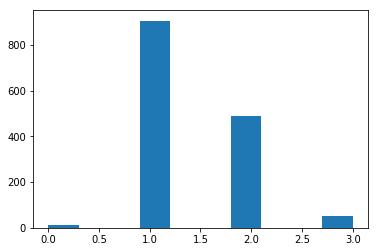

In [456]:
plt.hist(train['exterior_quality'])
# Not working - where is the plot?

(array([  1.00000000e+00,   0.00000000e+00,   2.80000000e+01,
          0.00000000e+00,   0.00000000e+00,   1.28200000e+03,
          0.00000000e+00,   1.46000000e+02,   0.00000000e+00,
          3.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

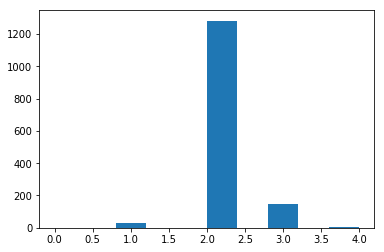

In [457]:
plt.hist(train['exterior_condition'])

In [458]:
train[['exterior_quality','exterior_condition']].corr()  # Correlation is just 0.009, good!

exterior_quality  exterior_condition
exterior_quality            1.000000            0.009184
exterior_condition          0.009184            1.000000

In [459]:
import numpy as np
np.histogram(train.exterior_quality)

(array([ 14,   0,   0, 906,   0,   0, 488,   0,   0,  52]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]))

###### Foundation: Type of foundation

In [460]:
print((train.Foundation.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.Foundation.value_counts().sort_values(ascending = False)/N*100).round(2))

PConc     44.32
CBlock    43.42
BrkTil    10.00
Slab       1.64
Stone      0.41
Wood       0.21
Name: Foundation, dtype: float64


In [461]:
# Building dummies and dropping some:
temp = pd.get_dummies(train.Foundation, prefix = "found")
temp.drop('found_Stone', axis=1, inplace = True)
temp.drop('found_Wood', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [462]:
temp = pd.get_dummies(test.Foundation, prefix = "found")
temp.drop('found_Stone', axis=1, inplace = True)
temp.drop('found_Wood', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [463]:
# print(pd.crosstab(train.found_PConc, train.Foundation))
# print(pd.crosstab(train.found_CBlock, train.Foundation))
# print(pd.crosstab(train.found_BrkTil, train.Foundation))
# print(pd.crosstab(train.found_Slab, train.Foundation))

In [464]:
# print(pd.crosstab(test.found_PConc, test.Foundation))
# print(pd.crosstab(test.found_CBlock, test.Foundation))
# print(pd.crosstab(test.found_BrkTil, test.Foundation))
# print(pd.crosstab(test.found_Slab, test.Foundation))

In [465]:
print(train.shape)
print(test.shape)

(1460, 158)
(1459, 157)


In [466]:
# correlations among them:
train[['found_BrkTil','found_CBlock','found_PConc', 'found_Slab']].corr()

found_BrkTil  found_CBlock  found_PConc  found_Slab
found_BrkTil      1.000000     -0.292034    -0.297362   -0.043093
found_CBlock     -0.292034      1.000000    -0.781558   -0.113262
found_PConc      -0.297362     -0.781558     1.000000   -0.115328
found_Slab       -0.043093     -0.113262    -0.115328    1.000000

###### BsmtQual: Evaluates the height of the basement

Created quantitative variable bsmt_height

In [467]:
# Replacing NAs with 'None' in both data frames:
train['BsmtQual'].fillna('NoBasement', inplace=True)
test['BsmtQual'].fillna('NoBasement', inplace=True)

In [468]:
print((train.BsmtQual.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.BsmtQual.value_counts().sort_values(ascending = False)/N*100).round(2))

TA            44.45
Gd            42.33
Ex             8.29
NoBasement     2.53
Fa             2.40
Name: BsmtQual, dtype: float64
TA            43.42
Gd            40.48
Ex             9.38
Fa             3.63
NoBasement     3.01
Name: BsmtQual, dtype: float64


In [469]:
train['bsmt_height'] = 0
train.loc[(train.BsmtQual == 'Fa'), 'bsmt_height'] = 1
train.loc[(train.BsmtQual == 'TA'), 'bsmt_height'] = 2
train.loc[(train.BsmtQual == 'Gd'), 'bsmt_height'] = 3
train.loc[(train.BsmtQual == 'Ex'), 'bsmt_height'] = 4
pd.crosstab(train.BsmtQual, train.bsmt_height)

bsmt_height   0   1    2    3    4
BsmtQual                          
Ex            0   0    0    0  121
Fa            0  35    0    0    0
Gd            0   0    0  618    0
NoBasement   37   0    0    0    0
TA            0   0  649    0    0

In [470]:
test['bsmt_height'] = 0
test.loc[(test.BsmtQual == 'Fa'), 'bsmt_height'] = 1
test.loc[(test.BsmtQual == 'TA'), 'bsmt_height'] = 2
test.loc[(test.BsmtQual == 'Gd'), 'bsmt_height'] = 3
test.loc[(test.BsmtQual == 'Ex'), 'bsmt_height'] = 4
pd.crosstab(test.BsmtQual, test.bsmt_height)

bsmt_height   0   1    2    3    4
BsmtQual                          
Ex            0   0    0    0  137
Fa            0  53    0    0    0
Gd            0   0    0  591    0
NoBasement   44   0    0    0    0
TA            0   0  634    0    0

In [471]:
print(train.shape)
print(test.shape)

(1460, 159)
(1459, 158)


###### BsmtCond: Evaluates the general condition of the basement

In [472]:
# Replacing NAs with 'None' in both data frames:
train['BsmtCond'].fillna('NoBasement', inplace=True)
test['BsmtCond'].fillna('NoBasement', inplace=True)

In [473]:
print((train.BsmtCond.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.BsmtCond.value_counts().sort_values(ascending = False)/N*100).round(2))

TA            89.79
Gd             4.45
Fa             3.08
NoBasement     2.53
Po             0.14
Name: BsmtCond, dtype: float64
TA            88.70
Fa             4.04
Gd             3.90
NoBasement     3.08
Po             0.21
Name: BsmtCond, dtype: float64


In [474]:
train['bsmt_condition'] = 0
train.loc[(train.BsmtCond == 'Po'), 'bsmt_condition'] = 1
train.loc[(train.BsmtCond == 'Fa'), 'bsmt_condition'] = 2
train.loc[(train.BsmtCond == 'TA'), 'bsmt_condition'] = 3
train.loc[(train.BsmtCond == 'Gd'), 'bsmt_condition'] = 4
pd.crosstab(train.BsmtCond, train.bsmt_condition)

bsmt_condition   0  1   2     3   4
BsmtCond                           
Fa               0  0  45     0   0
Gd               0  0   0     0  65
NoBasement      37  0   0     0   0
Po               0  2   0     0   0
TA               0  0   0  1311   0

In [475]:
test['bsmt_condition'] = 0
test.loc[(test.BsmtCond == 'Po'), 'bsmt_condition'] = 1
test.loc[(test.BsmtCond == 'Fa'), 'bsmt_condition'] = 2
test.loc[(test.BsmtCond == 'TA'), 'bsmt_condition'] = 3
test.loc[(test.BsmtCond == 'Gd'), 'bsmt_condition'] = 4
pd.crosstab(test.BsmtCond, test.bsmt_condition)

bsmt_condition   0  1   2     3   4
BsmtCond                           
Fa               0  0  59     0   0
Gd               0  0   0     0  57
NoBasement      45  0   0     0   0
Po               0  3   0     0   0
TA               0  0   0  1295   0

In [476]:
print(train.shape)
print(test.shape)

(1460, 160)
(1459, 159)


In [477]:
train[['bsmt_height','bsmt_condition']].corr()  # Correlation is 0.536

bsmt_height  bsmt_condition
bsmt_height        1.000000        0.535957
bsmt_condition     0.535957        1.000000

In [478]:
train[['found_Slab','bsmt_condition']].corr()  # Correlation is -0.69

found_Slab  bsmt_condition
found_Slab        1.000000       -0.687403
bsmt_condition   -0.687403        1.000000

In [479]:
pd.crosstab(train.bsmt_condition, train.found_Slab)

found_Slab         0   1
bsmt_condition          
0                 13  24
1                  2   0
2                 45   0
3               1311   0
4                 65   0

###### BsmtExposure: Refers to walkout or garden level walls

In [480]:
# Replacing NAs with 'None' in both data frames:
train['BsmtExposure'].fillna('NoBasement', inplace=True)
test['BsmtExposure'].fillna('NoBasement', inplace=True)

In [481]:
print((train.BsmtExposure.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.BsmtExposure.value_counts().sort_values(ascending = False)/N*100).round(2))

No            65.27
Av            15.14
Gd             9.18
Mn             7.81
NoBasement     2.60
Name: BsmtExposure, dtype: float64
No            65.14
Av            13.49
Gd             9.73
Mn             8.56
NoBasement     3.01
Name: BsmtExposure, dtype: float64


In [482]:
train['bsmt_exposure'] = 0
train.loc[(train.BsmtExposure == 'Mn'), 'bsmt_exposure'] = 1
train.loc[(train.BsmtExposure == 'Av'), 'bsmt_exposure'] = 2
train.loc[(train.BsmtExposure == 'Gd'), 'bsmt_exposure'] = 3
pd.crosstab(train.BsmtExposure, train.bsmt_exposure)

bsmt_exposure    0    1    2    3
BsmtExposure                     
Av               0    0  221    0
Gd               0    0    0  134
Mn               0  114    0    0
No             953    0    0    0
NoBasement      38    0    0    0

In [483]:
test['bsmt_exposure'] = 0
test.loc[(test.BsmtExposure == 'Mn'), 'bsmt_exposure'] = 1
test.loc[(test.BsmtExposure == 'Av'), 'bsmt_exposure'] = 2
test.loc[(test.BsmtExposure == 'Gd'), 'bsmt_exposure'] = 3
pd.crosstab(test.BsmtExposure, test.bsmt_exposure)

bsmt_exposure    0    1    2    3
BsmtExposure                     
Av               0    0  197    0
Gd               0    0    0  142
Mn               0  125    0    0
No             951    0    0    0
NoBasement      44    0    0    0

In [484]:
print(train.shape)
print(test.shape)

(1460, 161)
(1459, 160)


###### BsmtFinType1: Rating of basement finished area

Created 2 quantitative vars: bsmt_finished1 and bsmt_finished2

In [485]:
# Replacing NAs with 'None' in both data frames:
train['BsmtFinType1'].fillna('NoBasement', inplace=True)
train['BsmtFinType2'].fillna('NoBasement', inplace=True)
test['BsmtFinType1'].fillna('NoBasement', inplace=True)
test['BsmtFinType2'].fillna('NoBasement', inplace=True)

In [486]:
# print((train.BsmtFinType1.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.BsmtFinType2.value_counts().sort_values(ascending = False)/N*100).round(2))

In [487]:
# print((test.BsmtFinType1.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.BsmtFinType2.value_counts().sort_values(ascending = False)/N*100).round(2))

In [488]:
train['bsmt_finished1'] = 0
train.loc[(train.BsmtFinType1 == 'Unf'), 'bsmt_finished1'] = 1
train.loc[(train.BsmtFinType1 == 'LwQ'), 'bsmt_finished1'] = 1
train.loc[(train.BsmtFinType1 == 'BLQ'), 'bsmt_finished1'] = 2
train.loc[(train.BsmtFinType1 == 'Rec'), 'bsmt_finished1'] = 2
train.loc[(train.BsmtFinType1 == 'ALQ'), 'bsmt_finished1'] = 3
train.loc[(train.BsmtFinType1 == 'GLQ'), 'bsmt_finished1'] = 4
pd.crosstab(train.BsmtFinType1, train.bsmt_finished1)

bsmt_finished1   0    1    2    3    4
BsmtFinType1                          
ALQ              0    0    0  220    0
BLQ              0    0  148    0    0
GLQ              0    0    0    0  418
LwQ              0   74    0    0    0
NoBasement      37    0    0    0    0
Rec              0    0  133    0    0
Unf              0  430    0    0    0

In [489]:
train['bsmt_finished2'] = 0
train.loc[(train.BsmtFinType2 == 'Unf'), 'bsmt_finished2'] = 1
train.loc[(train.BsmtFinType2 == 'LwQ'), 'bsmt_finished2'] = 1
train.loc[(train.BsmtFinType2 == 'BLQ'), 'bsmt_finished2'] = 2
train.loc[(train.BsmtFinType2 == 'Rec'), 'bsmt_finished2'] = 2
train.loc[(train.BsmtFinType2 == 'ALQ'), 'bsmt_finished2'] = 3
train.loc[(train.BsmtFinType2 == 'GLQ'), 'bsmt_finished2'] = 4
pd.crosstab(train.BsmtFinType2, train.bsmt_finished1)

bsmt_finished1   0    1    2    3    4
BsmtFinType2                          
ALQ              0    9    6    0    4
BLQ              0    4   12   15    2
GLQ              0    7    5    2    0
LwQ              0    0   21   15   10
NoBasement      37    0    0    0    1
Rec              0    8   15   22    9
Unf              0  476  222  166  392

In [490]:
test['bsmt_finished1'] = 0
test.loc[(test.BsmtFinType1 == 'Unf'), 'bsmt_finished1'] = 1
test.loc[(test.BsmtFinType1 == 'LwQ'), 'bsmt_finished1'] = 1
test.loc[(test.BsmtFinType1 == 'BLQ'), 'bsmt_finished1'] = 2
test.loc[(test.BsmtFinType1 == 'Rec'), 'bsmt_finished1'] = 2
test.loc[(test.BsmtFinType1 == 'ALQ'), 'bsmt_finished1'] = 3
test.loc[(test.BsmtFinType1 == 'GLQ'), 'bsmt_finished1'] = 4
pd.crosstab(test.BsmtFinType1, test.bsmt_finished1)

bsmt_finished1   0    1    2    3    4
BsmtFinType1                          
ALQ              0    0    0  209    0
BLQ              0    0  121    0    0
GLQ              0    0    0    0  431
LwQ              0   80    0    0    0
NoBasement      42    0    0    0    0
Rec              0    0  155    0    0
Unf              0  421    0    0    0

In [491]:
test['bsmt_finished2'] = 0
test.loc[(test.BsmtFinType2 == 'Unf'), 'bsmt_finished2'] = 1
test.loc[(test.BsmtFinType2 == 'LwQ'), 'bsmt_finished2'] = 1
test.loc[(test.BsmtFinType2 == 'BLQ'), 'bsmt_finished2'] = 2
test.loc[(test.BsmtFinType2 == 'Rec'), 'bsmt_finished2'] = 2
test.loc[(test.BsmtFinType2 == 'ALQ'), 'bsmt_finished2'] = 3
test.loc[(test.BsmtFinType2 == 'GLQ'), 'bsmt_finished2'] = 4
pd.crosstab(test.BsmtFinType2, test.bsmt_finished2)

bsmt_finished2   0     1   2   3   4
BsmtFinType2                        
ALQ              0     0   0  33   0
BLQ              0     0  35   0   0
GLQ              0     0   0   0  20
LwQ              0    41   0   0   0
NoBasement      42     0   0   0   0
Rec              0     0  51   0   0
Unf              0  1237   0   0   0

In [492]:
print(train.shape)
print(test.shape)

(1460, 163)
(1459, 162)


###### Basement Square Footage - create a new var - share of finished

In [493]:
train['BsmtFinishedShare'] = 1 - train['BsmtUnfSF']/train['TotalBsmtSF']
train.loc[train.TotalBsmtSF == 0, 'BsmtFinishedShare'] = 0

In [494]:
test['BsmtFinishedShare'] = 1 - test['BsmtUnfSF']/test['TotalBsmtSF']
test.loc[test.TotalBsmtSF == 0, 'BsmtFinishedShare'] = 0

In [495]:
# train[['BsmtUnfSF','TotalBsmtSF','BsmtFinishedShare']]

In [496]:
train['BsmtFinishedShare'].corr(train['TotalBsmtSF'])  # correlation is 0.17

0.17388520502907454

In [497]:
train['BsmtFinishedShare'].corr(train['TotalBsmtSF'])  # correlation is 0.17

0.17388520502907454

In [498]:
test['BsmtUnfSF'].corr(test['TotalBsmtSF'])  # correlation is 0.41

0.40902319772896112

(array([ 501.,    5.,    2.,    5.,    6.,   11.,   16.,   13.,   14.,
          20.,   23.,   19.,   19.,   26.,   33.,   68.,   28.,   44.,
          33.,   48.,   47.,   60.,   57.,   62.,   68.,   38.,   50.,
          32.,   22.,   90.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 30 Patch objects>)

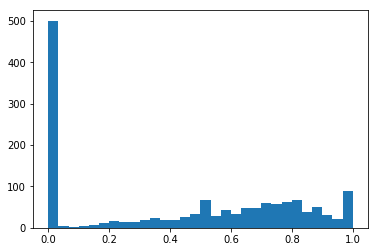

In [499]:
plt.hist(train.BsmtFinishedShare, bins = 30)

###### Heating: Type of heating - IGNORE, too little variance

In [500]:
print((train.Heating.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.Heating.value_counts().sort_values(ascending = False)/N*100).round(2))

GasA     97.81
GasW      1.23
Grav      0.48
Wall      0.27
OthW      0.14
Floor     0.07
Name: Heating, dtype: float64
GasA    99.04
GasW     0.62
Grav     0.14
Wall     0.14
Name: Heating, dtype: float64


###### HeatingQC: Heating quality and condition

Created quantitative variable 'heating_quality'

In [501]:
print((train.HeatingQC.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.HeatingQC.value_counts().sort_values(ascending = False)/N*100).round(2))

Ex    50.75
TA    29.32
Gd    16.51
Fa     3.36
Po     0.07
Name: HeatingQC, dtype: float64
Ex    51.51
TA    29.38
Gd    15.96
Fa     2.95
Po     0.14
Name: HeatingQC, dtype: float64


In [502]:
train['heating_quality'] = 0
train.loc[train.HeatingQC == 'Fa', 'heating_quality'] = 1
train.loc[train.HeatingQC == 'TA', 'heating_quality'] = 2
train.loc[train.HeatingQC == 'Gd', 'heating_quality'] = 3
train.loc[train.HeatingQC == 'Ex', 'heating_quality'] = 4
pd.crosstab(train.HeatingQC, train.heating_quality)

heating_quality  0   1    2    3    4
HeatingQC                            
Ex               0   0    0    0  741
Fa               0  49    0    0    0
Gd               0   0    0  241    0
Po               1   0    0    0    0
TA               0   0  428    0    0

In [503]:
test['heating_quality'] = 0
test.loc[test.HeatingQC == 'Fa', 'heating_quality'] = 1
test.loc[test.HeatingQC == 'TA', 'heating_quality'] = 2
test.loc[test.HeatingQC == 'Gd', 'heating_quality'] = 3
test.loc[test.HeatingQC == 'Ex', 'heating_quality'] = 4
pd.crosstab(test.HeatingQC, test.heating_quality)

heating_quality  0   1    2    3    4
HeatingQC                            
Ex               0   0    0    0  752
Fa               0  43    0    0    0
Gd               0   0    0  233    0
Po               2   0    0    0    0
TA               0   0  429    0    0

In [504]:
print(train.shape)
print(test.shape)

(1460, 165)
(1459, 164)


###### CentralAir: Central air conditioning

In [505]:
print((train.CentralAir.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.CentralAir.value_counts().sort_values(ascending = False)/N*100).round(2))

Y    93.49
N     6.51
Name: CentralAir, dtype: float64
Y    93.01
N     6.92
Name: CentralAir, dtype: float64


In [506]:
# Creating a dummy:
train['central_air'] = 0
train.loc[train.CentralAir == 'Y', 'central_air'] = 1
pd.crosstab(train.CentralAir, train.central_air)

central_air   0     1
CentralAir           
N            95     0
Y             0  1365

In [507]:
test['central_air'] = 0
test.loc[test.CentralAir == 'Y', 'central_air'] = 1
pd.crosstab(test.CentralAir, test.central_air)

central_air    0     1
CentralAir            
N            101     0
Y              0  1358

###### Electrical: Electrical system

In [508]:
print((train.Electrical.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.Electrical.value_counts().sort_values(ascending = False)/N*100).round(2))

SBrkr    91.37
FuseA     6.44
FuseF     1.85
FuseP     0.21
Mix       0.07
Name: Electrical, dtype: float64
SBrkr    91.58
FuseA     6.44
FuseF     1.58
FuseP     0.34
Name: Electrical, dtype: float64


In [509]:
# Creating 2 dummies:
train['elec_sbrkr'] = 0
train.loc[train.Electrical == 'SBrkr', 'elec_sbrkr'] = 1
train['elec_fuseA'] = 0
train.loc[train.Electrical == 'FuseA', 'elec_fuseA'] = 1

In [510]:
test['elec_sbrkr'] = 0
test.loc[test.Electrical == 'SBrkr', 'elec_sbrkr'] = 1
test['elec_fuseA'] = 0
test.loc[test.Electrical == 'FuseA', 'elec_fuseA'] = 1

In [511]:
print(train.shape)
print(test.shape)

(1460, 168)
(1459, 167)


###### KitchenQual: Kitchen quality

Created a numeric variable kitchen_quality

In [512]:
print((train.KitchenQual.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.KitchenQual.value_counts().sort_values(ascending = False)/N*100).round(2))

TA    50.34
Gd    40.14
Ex     6.85
Fa     2.67
Name: KitchenQual, dtype: float64
TA    51.85
Gd    38.70
Ex     7.19
Fa     2.12
Name: KitchenQual, dtype: float64


In [513]:
train['kitchen_quality'] = 0
train.loc[train.KitchenQual == 'TA', 'kitchen_quality'] = 1
train.loc[train.KitchenQual == 'Gd', 'kitchen_quality'] = 2
train.loc[train.KitchenQual == 'Ex', 'kitchen_quality'] = 3
pd.crosstab(train.KitchenQual, train.kitchen_quality)

kitchen_quality   0    1    2    3
KitchenQual                       
Ex                0    0    0  100
Fa               39    0    0    0
Gd                0    0  586    0
TA                0  735    0    0

In [514]:
test['kitchen_quality'] = 0
test.loc[test.KitchenQual == 'TA', 'kitchen_quality'] = 1
test.loc[test.KitchenQual == 'Gd', 'kitchen_quality'] = 2
test.loc[test.KitchenQual == 'Ex', 'kitchen_quality'] = 3
pd.crosstab(test.KitchenQual, test.kitchen_quality)

kitchen_quality   0    1    2    3
KitchenQual                       
Ex                0    0    0  105
Fa               31    0    0    0
Gd                0    0  565    0
TA                0  757    0    0

###### Functional: Home functionality (Assume typical unless deductions are warranted)

Created quantiative variable home_funct

In [515]:
# print((train.Functional.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.Functional.value_counts().sort_values(ascending = False)/N*100).round(2))

In [516]:
train['home_funct'] = 0
train.loc[train.Functional == 'Sev', 'home_funct'] = 0
train.loc[train.Functional == 'Maj2', 'home_funct'] = 1
train.loc[train.Functional == 'Maj1', 'home_funct'] = 1.5
train.loc[train.Functional == 'Mod', 'home_funct'] = 3
train.loc[train.Functional == 'Min2', 'home_funct'] = 5
train.loc[train.Functional == 'Min1', 'home_funct'] = 5.5
train.loc[train.Functional == 'Typ', 'home_funct'] = 7
pd.crosstab(train.Functional, train.home_funct)

home_funct  0.0  1.0  1.5  3.0  5.0  5.5   7.0
Functional                                    
Maj1          0    0   14    0    0    0     0
Maj2          0    5    0    0    0    0     0
Min1          0    0    0    0    0   31     0
Min2          0    0    0    0   34    0     0
Mod           0    0    0   15    0    0     0
Sev           1    0    0    0    0    0     0
Typ           0    0    0    0    0    0  1360

In [517]:
test['home_funct'] = 0
test.loc[test.Functional == 'Sev', 'home_funct'] = 0
test.loc[test.Functional == 'Maj2', 'home_funct'] = 1
test.loc[test.Functional == 'Maj1', 'home_funct'] = 1.5
test.loc[test.Functional == 'Mod', 'home_funct'] = 3
test.loc[test.Functional == 'Min2', 'home_funct'] = 5
test.loc[test.Functional == 'Min1', 'home_funct'] = 5.5
test.loc[test.Functional == 'Typ', 'home_funct'] = 7
pd.crosstab(test.Functional, test.home_funct)

home_funct  0.0  1.0  1.5  3.0  5.0  5.5   7.0
Functional                                    
Maj1          0    0    5    0    0    0     0
Maj2          0    4    0    0    0    0     0
Min1          0    0    0    0    0   34     0
Min2          0    0    0    0   36    0     0
Mod           0    0    0   20    0    0     0
Sev           1    0    0    0    0    0     0
Typ           0    0    0    0    0    0  1357

###### Fireplaces: Number of fireplaces

Create a new dummy: fireplace present vs. not
Create a new var that combines number of fireplaces with their quality?

In [518]:
print((train.Fireplaces.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.Fireplaces.value_counts().sort_values(ascending = False)/N*100).round(2))

0    47.26
1    44.52
2     7.88
3     0.34
Name: Fireplaces, dtype: float64
0    50.00
1    42.33
2     7.12
3     0.41
4     0.07
Name: Fireplaces, dtype: float64


In [519]:
print(train.shape)
print(test.shape)

(1460, 170)
(1459, 169)


###### FireplaceQu: Fireplace quality

Creating variable fireplace_quality
Consider no fireplace same as Poor quality - just for the sake of it

In [520]:
np.sum(train.FireplaceQu.isnull(), axis=0)/N*100

47.260273972602739

In [521]:
print((train.FireplaceQu.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.FireplaceQu.value_counts().sort_values(ascending = False)/N*100).round(2))

Gd    26.03
TA    21.44
Fa     2.26
Ex     1.64
Po     1.37
Name: FireplaceQu, dtype: float64
Gd    24.93
TA    19.11
Fa     2.81
Po     1.78
Ex     1.30
Name: FireplaceQu, dtype: float64


In [522]:
print(train.shape)
print(test.shape)

(1460, 170)
(1459, 169)


In [523]:
# Creating a quantitative variable - treating "no fireplace" as the worst level (zero)
train['fireplace_quality'] = 0
train.loc[train.FireplaceQu == 'Po', 'fireplace_quality'] = 1
train.loc[train.FireplaceQu == 'Fa', 'fireplace_quality'] = 1  # same as Ben Franklin Stove
train.loc[train.FireplaceQu == 'TA', 'fireplace_quality'] = 2
train.loc[train.FireplaceQu == 'Gd', 'fireplace_quality'] = 3
train.loc[train.Functional == 'Ex', 'fireplace_quality'] = 3.5
# pd.crosstab(train.FireplaceQu, train.fireplace_quality)

In [524]:
pd.crosstab(train.FireplaceQu, train.fireplace_quality)

fireplace_quality  0.0  1.0  2.0  3.0
FireplaceQu                          
Ex                  24    0    0    0
Fa                   0   33    0    0
Gd                   0    0    0  380
Po                   0   20    0    0
TA                   0    0  313    0

In [525]:
test['fireplace_quality'] = 0
test.loc[test.FireplaceQu == 'Po', 'fireplace_quality'] = 1
test.loc[test.FireplaceQu == 'Fa', 'fireplace_quality'] = 1  # same as Ben Franklin Stove
test.loc[test.FireplaceQu == 'TA', 'fireplace_quality'] = 2
test.loc[test.FireplaceQu == 'Gd', 'fireplace_quality'] = 3
test.loc[test.Functional == 'Ex', 'fireplace_quality'] = 3.5
# pd.crosstab(test.FireplaceQu, test.fireplace_quality)

In [526]:
print(train.shape)
print(test.shape)

(1460, 171)
(1459, 170)


###### Dealing with Fireplaces (number of fireplaces)

In [527]:
# print((train.Fireplaces.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.Fireplaces.value_counts().sort_values(ascending = False)/N*100).round(2))

In [528]:
print(pd.crosstab(train.Fireplaces, train.fireplace_quality))
train['Fireplaces'].corr(train['fireplace_quality'])

fireplace_quality  0.0  1.0  2.0  3.0
Fireplaces                           
0                  690    0    0    0
1                   19   48  259  324
2                    4    4   53   54
3                    1    1    1    2


0.81402413283074637

In [529]:
# Replacing with NAs those values of fireplace_quality that were actually missing originally:
train.loc[(train.Fireplaces>0)&(train.fireplace_quality == 0), 'fireplace_quality'] = None

In [530]:
test.loc[(test.Fireplaces>0)&(test.fireplace_quality == 0), 'fireplace_quality'] = None

In [531]:
# Create product of fireplace_quality and Fireplaces:
train['fireplace_ttlscore'] = train['Fireplaces'] * train['fireplace_quality']
test['fireplace_ttlscore'] = test['Fireplaces'] * test['fireplace_quality']

In [532]:
print(train['Fireplaces'].corr(train['fireplace_quality']))
print(train['Fireplaces'].corr(train['fireplace_ttlscore']))
print(train['fireplace_quality'].corr(train['fireplace_ttlscore']))

0.847896723198
0.944974389693
0.909698813626


###### GarageType: Garage location

Building a quantitative var gar_type

In [533]:
print((train.GarageType.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.GarageType.value_counts().sort_values(ascending = False)/N*100).round(2))

Attchd     59.59
Detchd     26.51
BuiltIn     6.03
Basment     1.30
CarPort     0.62
2Types      0.41
Name: GarageType, dtype: float64
Attchd     58.42
Detchd     26.85
BuiltIn     6.71
2Types      1.16
Basment     1.16
CarPort     0.41
Name: GarageType, dtype: float64


In [534]:
# Creating a quantitative variable - treating "no garage" as the worst level (zero)
train['gar_type'] = 0
train.loc[train.GarageType == 'CarPort', 'gar_type'] = 1
train.loc[train.GarageType == 'Detchd', 'gar_type'] = 1.5
train.loc[train.GarageType == 'Attchd', 'gar_type'] = 2
train.loc[train.GarageType == 'Basment', 'gar_type'] = 2   # same as Attached
train.loc[train.GarageType == 'BuiltIn', 'gar_type'] = 2.5
train.loc[train.GarageType == '2Types', 'gar_type'] = 3
pd.crosstab(train.GarageType, train.gar_type)

gar_type    1.0  1.5  2.0  2.5  3.0
GarageType                         
2Types        0    0    0    0    6
Attchd        0    0  870    0    0
Basment       0    0   19    0    0
BuiltIn       0    0    0   88    0
CarPort       9    0    0    0    0
Detchd        0  387    0    0    0

In [535]:
test['gar_type'] = 0
test.loc[test.GarageType == 'CarPort', 'gar_type'] = 1
test.loc[test.GarageType == 'Detchd', 'gar_type'] = 1.5
test.loc[test.GarageType == 'Attchd', 'gar_type'] = 2
test.loc[test.GarageType == 'Basment', 'gar_type'] = 2   # same as Attached
test.loc[test.GarageType == 'BuiltIn', 'gar_type'] = 2.5
test.loc[test.GarageType == '2Types', 'gar_type'] = 3
pd.crosstab(test.GarageType, test.gar_type)

gar_type    1.0  1.5  2.0  2.5  3.0
GarageType                         
2Types        0    0    0    0   17
Attchd        0    0  853    0    0
Basment       0    0   17    0    0
BuiltIn       0    0    0   98    0
CarPort       6    0    0    0    0
Detchd        0  392    0    0    0

In [536]:
print(train.shape)
print(test.shape)

(1460, 173)
(1459, 172)


###### GarageYrBlt: Year garage was built

Unless there are other ideas - I'd suggest to drop the year garage was built for 3 reasons:
1. It's highly correlated (0.82) with year the house was built - see next cell.
2. 5.5% of people have no garage, so it's not clear how to code this variable when people have no garage.
3. When you guy a house you rarely care about the year it was built - you care about its size, location, condition.

In [537]:
train['GarageYrBlt'].corr(train['YearBuilt'])  # correlation is 0.82

0.82566748417434199

###### GarageFinish: Interior finish of the garage

In [538]:
print((train.GarageFinish.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.GarageFinish.value_counts().sort_values(ascending = False)/N*100).round(2))

Unf    41.44
RFn    28.90
Fin    24.11
Name: GarageFinish, dtype: float64
Unf    42.81
RFn    26.64
Fin    25.14
Name: GarageFinish, dtype: float64


In [539]:
# Creating a quantitative variable - treating "no garage" as the worst level (zero)
train['gar_finish'] = 0
train.loc[train.GarageFinish == 'Unf', 'gar_finish'] = 1
train.loc[train.GarageFinish == 'RFn', 'gar_finish'] = 2
train.loc[train.GarageFinish == 'Fin', 'gar_finish'] = 3
pd.crosstab(train.GarageFinish, train.gar_finish)

gar_finish      1    2    3
GarageFinish               
Fin             0    0  352
RFn             0  422    0
Unf           605    0    0

In [540]:
test['gar_finish'] = 0
test.loc[test.GarageFinish == 'Unf', 'gar_finish'] = 1
test.loc[test.GarageFinish == 'RFn', 'gar_finish'] = 2
test.loc[test.GarageFinish == 'Fin', 'gar_finish'] = 3
pd.crosstab(test.GarageFinish, test.gar_finish)

gar_finish      1    2    3
GarageFinish               
Fin             0    0  367
RFn             0  389    0
Unf           625    0    0

In [541]:
print(train.shape)
print(test.shape)

(1460, 174)
(1459, 173)


###### GarageCars: Size of garage in car capacity, GarageArea: Size of garage in square feet

Let's only use GarageCars (as is) and forget about GarageArea - garage square feet are correlated with GarageCars at 0.88 

In [542]:
# Can use as is:
print((train.GarageCars.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.GarageCars.value_counts().sort_values(ascending = False)/N*100).round(2))
print(train['GarageArea'].corr(train['GarageCars']))  # correlation is 0.88
print(train['GarageArea'].corr(train['SalePrice']))  # correlation is 0.6234
print(train['GarageCars'].corr(train['SalePrice']))  # correlation is 0.6405

2    56.44
1    25.27
3    12.40
0     5.55
4     0.34
Name: GarageCars, dtype: float64
2.0    52.74
1.0    27.88
3.0    13.22
0.0     5.21
4.0     0.75
5.0     0.07
Name: GarageCars, dtype: float64
0.882475414281
0.623431438918
0.640409197258


###### GarageQual: Garage quality

In [543]:
print((train.GarageQual.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.GarageQual.value_counts().sort_values(ascending = False)/N*100).round(2))

TA    89.79
Fa     3.29
Gd     0.96
Po     0.21
Ex     0.21
Name: GarageQual, dtype: float64
TA    88.56
Fa     5.21
Gd     0.68
Po     0.14
Name: GarageQual, dtype: float64


In [544]:
pd.crosstab(train.GarageQual, train.GarageCond)

GarageCond  Ex  Fa  Gd  Po    TA
GarageQual                      
Ex           2   0   0   0     1
Fa           0  20   0   4    24
Gd           0   0   4   0    10
Po           0   0   0   3     0
TA           0  15   5   0  1291

In [545]:
# GarageQual
# Creating a quantitative variable - treating "no garage" as the average level (no headache)
train['gar_qual'] = 3
train.loc[train.GarageQual == 'Po', 'gar_qual'] = 1
train.loc[train.GarageQual == 'Fa', 'gar_qual'] = 2
train.loc[train.GarageQual == 'Gd', 'gar_qual'] = 3.5
train.loc[train.GarageQual == 'Ex', 'gar_qual'] = 4
pd.crosstab(train.GarageQual, train.gar_qual)

gar_qual    1.0  2.0   3.0  3.5  4.0
GarageQual                          
Ex            0    0     0    0    3
Fa            0   48     0    0    0
Gd            0    0     0   14    0
Po            3    0     0    0    0
TA            0    0  1311    0    0

In [546]:
test['gar_qual'] = 3
test.loc[test.GarageQual == 'Po', 'gar_qual'] = 1
test.loc[test.GarageQual == 'Fa', 'gar_qual'] = 2
test.loc[test.GarageQual == 'Gd', 'gar_qual'] = 3.5
test.loc[test.GarageQual == 'Ex', 'gar_qual'] = 4
pd.crosstab(test.GarageQual, test.gar_qual)

gar_qual    1.0  2.0   3.0  3.5
GarageQual                     
Fa            0   76     0    0
Gd            0    0     0   10
Po            2    0     0    0
TA            0    0  1293    0

In [547]:
print((train.GarageCond.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.GarageCond.value_counts().sort_values(ascending = False)/N*100).round(2))

TA    90.82
Fa     2.40
Gd     0.62
Po     0.48
Ex     0.14
Name: GarageCond, dtype: float64
TA    90.96
Fa     2.67
Po     0.48
Gd     0.41
Ex     0.07
Name: GarageCond, dtype: float64


In [548]:
# GarageCond
# Creating a quantitative variable - treating "no garage" as the average level (no headache)
train['gar_cond'] = 2
train.loc[train.GarageCond == 'Po', 'gar_cond'] = 1
train.loc[train.GarageCond == 'Fa', 'gar_cond'] = 1.5
train.loc[train.GarageCond == 'Gd', 'gar_cond'] = 2.5
train.loc[train.GarageCond == 'Ex', 'gar_cond'] = 3
pd.crosstab(train.GarageCond, train.gar_cond)

gar_cond    1.0  1.5   2.0  2.5  3.0
GarageCond                          
Ex            0    0     0    0    2
Fa            0   35     0    0    0
Gd            0    0     0    9    0
Po            7    0     0    0    0
TA            0    0  1326    0    0

In [549]:
test['gar_cond'] = 2
test.loc[test.GarageCond == 'Po', 'gar_cond'] = 1
test.loc[test.GarageCond == 'Fa', 'gar_cond'] = 1.5
test.loc[test.GarageCond == 'Gd', 'gar_cond'] = 2.5
test.loc[test.GarageCond == 'Ex', 'gar_cond'] = 3
pd.crosstab(test.GarageCond, test.gar_cond)

gar_cond    1.0  1.5   2.0  2.5  3.0
GarageCond                          
Ex            0    0     0    0    1
Fa            0   39     0    0    0
Gd            0    0     0    6    0
Po            7    0     0    0    0
TA            0    0  1328    0    0

In [550]:
# Creating a new variable - product of garage quality & condition:
train['gar_perception'] = train['gar_qual'] * train['gar_cond']
test['gar_perception'] = test['gar_qual'] * test['gar_cond']

In [551]:
# pd.crosstab(train.gar_qual, train.gar_perception)
# pd.crosstab(train.gar_cond, train.gar_perception)

In [552]:
print(train.shape)
print(test.shape)

(1460, 177)
(1459, 176)


###### PavedDrive: Paved driveway

In [553]:
print((train.PavedDrive.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.PavedDrive.value_counts().sort_values(ascending = False)/N*100).round(2))

Y    91.78
N     6.16
P     2.05
Name: PavedDrive, dtype: float64
Y    89.11
N     8.63
P     2.19
Name: PavedDrive, dtype: float64


In [554]:
# Creating a quantitative variable
train['driveway'] = 0
train.loc[train.PavedDrive == 'P', 'driveway'] = 2
train.loc[train.PavedDrive == 'Y', 'driveway'] = 3
pd.crosstab(train.PavedDrive, train.driveway)

driveway     0   2     3
PavedDrive              
N           90   0     0
P            0  30     0
Y            0   0  1340

In [555]:
test['driveway'] = 0
test.loc[test.PavedDrive == 'P', 'driveway'] = 2
test.loc[test.PavedDrive == 'Y', 'driveway'] = 3
pd.crosstab(test.PavedDrive, test.driveway)

driveway      0   2     3
PavedDrive               
N           126   0     0
P             0  32     0
Y             0   0  1301

In [556]:
print(train.shape)
print(test.shape)

(1460, 178)
(1459, 177)


###### Correlations for Porches SF - are pretty low, let's keep them all

In [557]:
train[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch', 'ScreenPorch']].corr()

WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch
WoodDeckSF       1.000000     0.058661      -0.125989  -0.032771    -0.074181
OpenPorchSF      0.058661     1.000000      -0.093079  -0.005842     0.074304
EnclosedPorch   -0.125989    -0.093079       1.000000  -0.037305    -0.082864
3SsnPorch       -0.032771    -0.005842      -0.037305   1.000000    -0.031436
ScreenPorch     -0.074181     0.074304      -0.082864  -0.031436     1.000000

###### PoolArea: Pool area in square feet & PoolQC- ignore, nobody has a pool

In [558]:
# plt.hist(test['PoolArea'])
# train.PoolArea.value_counts().sort_values(ascending = False)

In [559]:
print((train.PoolQC.value_counts().sort_values(ascending = False)/N*100).round(2))

Gd    0.21
Ex    0.14
Fa    0.14
Name: PoolQC, dtype: float64


###### Fence: Fence quality

Build a new var fence

In [560]:
print((train.Fence.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.Fence.value_counts().sort_values(ascending = False)/N*100).round(2))

MnPrv    10.75
GdPrv     4.04
GdWo      3.70
MnWw      0.75
Name: Fence, dtype: float64
MnPrv    11.78
GdPrv     4.04
GdWo      3.97
MnWw      0.07
Name: Fence, dtype: float64


In [561]:
train['fence'] = 0  # No fence are all zero 
train.loc[(train.Fence == 'MnWw')|(train.Fence == 'MnPrv'), 'fence'] = 0.5 # Minimum Wood or Minimum Privacy are 0.5
train.loc[(train.Fence == 'GdWo')|(train.Fence == 'GdPrv'), 'fence'] = 1.5
pd.crosstab(train.Fence, train.fence)

fence  0.5  1.5
Fence          
GdPrv    0   59
GdWo     0   54
MnPrv  157    0
MnWw    11    0

In [562]:
test['fence'] = 0  # No fence are all zero 
test.loc[(test.Fence == 'MnWw')|(test.Fence == 'MnPrv'), 'fence'] = 0.5 # Minimum Wood or Minimum Privacy are 0.5
test.loc[(test.Fence == 'GdWo')|(test.Fence == 'GdPrv'), 'fence'] = 1.5
pd.crosstab(test.Fence, test.fence)

fence  0.5  1.5
Fence          
GdPrv    0   59
GdWo     0   58
MnPrv  172    0
MnWw     1    0

In [563]:
print((train.fence.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.fence.value_counts().sort_values(ascending = False)/N*100).round(2))

0.0    80.75
0.5    11.51
1.5     7.74
Name: fence, dtype: float64
0.0    80.07
0.5    11.85
1.5     8.01
Name: fence, dtype: float64


###### MiscFeature: Miscellaneous feature not covered in other categories

In [564]:
print((train.MiscFeature.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.MiscFeature.value_counts().sort_values(ascending = False)/N*100).round(2))

Shed    3.36
Othr    0.14
Gar2    0.14
TenC    0.07
Name: MiscFeature, dtype: float64
Shed    3.15
Gar2    0.21
Othr    0.14
Name: MiscFeature, dtype: float64


In [565]:
# Build dummy variable 'shed':
train['shed'] = 0
train.loc[train.MiscFeature == 'Shed', 'shed'] = 1
pd.crosstab(train.MiscFeature, train.shed)

shed         0   1
MiscFeature       
Gar2         2   0
Othr         2   0
Shed         0  49
TenC         1   0

In [566]:
test['shed'] = 0
test.loc[test.MiscFeature == 'Shed', 'shed'] = 1
pd.crosstab(test.MiscFeature, test.shed)

shed         0   1
MiscFeature       
Gar2         3   0
Othr         2   0
Shed         0  46

###### MiscVal: $Value of miscellaneous feature - 96% are zeroes, but could use as is

In [567]:
# print((train.MiscVal.value_counts().sort_values(ascending = False)/N*100).round(2))

###### MoSold: Month Sold (MM) - could use as is

In [568]:
# print((train.MoSold.value_counts().sort_values(ascending = False)/N*100).round(2))

###### YrSold: Year Sold (YYYY) - could use as is

In [569]:
# print((train.YrSold.value_counts().sort_values(ascending = False)/N*100).round(2))

###### SaleType: Type of sale

In [570]:
print((train.SaleType.value_counts().sort_values(ascending = False)/N*100).round(2))

WD       86.78
New       8.36
COD       2.95
ConLD     0.62
ConLI     0.34
ConLw     0.34
CWD       0.27
Oth       0.21
Con       0.14
Name: SaleType, dtype: float64


In [571]:
# Build dummy variable 'sales_convent':
train['sales_convent'] = 0
train.loc[train.SaleType == 'WD', 'sales_convent'] = 1
# pd.crosstab(train.SaleType, train.sales_convent)

In [572]:
test['sales_convent'] = 0
test.loc[test.SaleType == 'WD', 'sales_convent'] = 1
# pd.crosstab(test.SaleType, test.sales_convent)

In [573]:
# Build dummy variable 'sales_new':
train['sales_new'] = 0
train.loc[train.SaleType == 'New', 'sales_new'] = 1
pd.crosstab(train.SaleType, train.sales_new)

sales_new     0    1
SaleType            
COD          43    0
CWD           4    0
Con           2    0
ConLD         9    0
ConLI         5    0
ConLw         5    0
New           0  122
Oth           3    0
WD         1267    0

In [574]:
test['sales_new'] = 0
test.loc[test.SaleType == 'New', 'sales_new'] = 1
pd.crosstab(test.SaleType, test.sales_new)

sales_new     0    1
SaleType            
COD          44    0
CWD           8    0
Con           3    0
ConLD        17    0
ConLI         4    0
ConLw         3    0
New           0  117
Oth           4    0
WD         1258    0

In [575]:
print(train.shape)
print(test.shape)

(1460, 182)
(1459, 181)


###### SaleCondition: Condition of sale

In [576]:
print((train.SaleCondition.value_counts().sort_values(ascending = False)/N*100).round(2))
print((test.SaleCondition.value_counts().sort_values(ascending = False)/N*100).round(2))

Normal     82.05
Partial     8.56
Abnorml     6.92
Family      1.37
Alloca      0.82
AdjLand     0.27
Name: SaleCondition, dtype: float64
Normal     82.47
Partial     8.22
Abnorml     6.10
Family      1.78
Alloca      0.82
AdjLand     0.55
Name: SaleCondition, dtype: float64


In [577]:
# Creating dummies based on SaleCondition and dropping two of them (with too few observations):
temp = pd.get_dummies(train.SaleCondition, prefix = "sale")
temp.drop('sale_Alloca', axis=1, inplace = True)
temp.drop('sale_AdjLand', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [578]:
temp = pd.get_dummies(test.SaleCondition, prefix = "sale")
temp.drop('sale_Alloca', axis=1, inplace = True)
temp.drop('sale_AdjLand', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [579]:
print(train.shape)
print(test.shape)

(1460, 186)
(1459, 185)


In [580]:
# print(train.columns)
# print(test.columns)

In [581]:
# misscounts = np.sum(train.isnull(), axis=0)/N*100
# print(misscounts[:40].round(2))
# print(misscounts[65:80].round(2))

###### YrSold: Year Sold (YYYY)

In [582]:
print((train.YrSold.value_counts().sort_values(ascending = False)/N*100).round(2))

2009    23.15
2007    22.53
2006    21.51
2008    20.82
2010    11.99
Name: YrSold, dtype: float64


In [583]:
train['salesyear_07'] = 0
train.loc[train.YrSold == 2007, 'salesyear_07'] = 1
train['salesyear_08'] = 0
train.loc[train.YrSold == 2008, 'salesyear_08'] = 1
train['salesyear_09'] = 0
train.loc[train.YrSold == 2009, 'salesyear_09'] = 1
train['salesyear_10'] = 0
train.loc[train.YrSold == 2010, 'salesyear_10'] = 1

In [584]:
test['salesyear_07'] = 0
test.loc[test.YrSold == 2007, 'salesyear_07'] = 1
test['salesyear_08'] = 0
test.loc[test.YrSold == 2008, 'salesyear_08'] = 1
test['salesyear_09'] = 0
test.loc[test.YrSold == 2009, 'salesyear_09'] = 1
test['salesyear_10'] = 0
test.loc[test.YrSold == 2010, 'salesyear_10'] = 1

In [585]:
# pd.crosstab(train.YrSold, train.salesyear_07)

In [586]:
print(train.shape)
print(test.shape)

(1460, 190)
(1459, 189)


###### MoSold: Month Sold (MM)

In [587]:
print((train.MoSold.value_counts().sort_values(ascending = False)/N*100).round(2))

6     17.33
7     16.03
5     13.97
4      9.66
8      8.36
3      7.26
10     6.10
11     5.41
9      4.32
12     4.04
1      3.97
2      3.56
Name: MoSold, dtype: float64


In [588]:
# Creating dummies based on SaleCondition and dropping two of them (with too few observations):
temp = pd.get_dummies(train.MoSold, prefix = "salesmo")
temp.drop('salesmo_1', axis=1, inplace = True)
temp.drop('salesmo_2', axis=1, inplace = True)
train = pd.concat([train, temp], axis = 1)

In [589]:
temp = pd.get_dummies(test.MoSold, prefix = "salesmo")
temp.drop('salesmo_1', axis=1, inplace = True)
temp.drop('salesmo_2', axis=1, inplace = True)
test = pd.concat([test, temp], axis = 1)

In [590]:
print(train.shape)
print(test.shape)

(1460, 200)
(1459, 199)


###### Building dummy 'remodeled' instead of YearRemodAdd

In [591]:
# Correlation year built and remodeled - we won't be using YearRemodAdd
train['YearBuilt'].corr(train['YearRemodAdd']) # 0.6

0.59285497634365036

In [592]:
# Build variable remodeled to be used instead of YearRemodAdd:
train['remodeled'] = 0
train.loc[train.YearBuilt != train.YearRemodAdd,'remodeled'] = 1

In [593]:
test['remodeled'] = 0
test.loc[test.YearBuilt != test.YearRemodAdd,'remodeled'] = 1

In [594]:
# pd.crosstab((train.YearBuilt-train.YearRemodAdd), train.remodeled)

In [595]:
pd.crosstab((train.remodeled), train.YearBuilt)

YearBuilt  1872  1875  1880  1882  1885  1890  1892  1893  1898  1900  1904  \
remodeled                                                                     
0             0     0     0     0     0     0     0     0     0     0     0   
1             1     1     4     1     2     2     2     1     1    10     1   

YearBuilt  1905  1906  1908  1910  1911  1912  1913  1914  1915  1916  1917  \
remodeled                                                                     
0             0     0     0     0     0     0     0     0     0     0     0   
1             1     1     2    17     1     3     1     7    10     8     1   

YearBuilt  1918  1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
remodeled                                                                     
0             0     0     0     0     0     0     0     0     0     0     0   
1             7     3    30     6     8     7     7    16     9     3     7   

YearBuilt  1929  1930  1931  1932  1934  1935  1936  ...   1971  1972  1973  \
remodeled                                            ...                      
0             0     0     0     0     0     0     0  ...     18    17    10   
1             4     9     6     4     3     6     9  ...      4     6     1   

YearBuilt  1974  1975  1976  1977  1978  1979  1980  1981  1982  1983  1984  \
remodeled                                                                     
0             6     6    28    25    14     8     9     4     3     3     5   
1             4     2     5     7     2     1     1     1     3     1     4   

YearBuilt  1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  1995  \
remodeled                                                                     
0             5     3     2     4     2     6     2     9     9     6     6   
1             0     2     1     7     1     6     3     4     8    13    12   

YearBuilt  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  \
remodeled                                                                     
0             8     8    18    17    22    10    19    28    30    33    46   
1             7     6     7     8     2    10     4    17    24    31    21   

YearBuilt  2007  2008  2009  2010  
remodeled                          
0            34    16    14     1  
1            15     7     4     0  

[2 rows x 112 columns]

###### Summing the number of baths

Created 2 new variables: full_baths and half_baths

In [596]:
# print((train.BsmtFullBath.value_counts().sort_values(ascending = False)/N*100).round(2))

In [597]:
# print((train.BsmtHalfBath.value_counts().sort_values(ascending = False)/N*100).round(2))

In [598]:
# print((train.FullBath.value_counts().sort_values(ascending = False)/N*100).round(2))

In [599]:
# print((train.HalfBath.value_counts().sort_values(ascending = False)/N*100).round(2))

In [600]:
train['full_baths'] = train['BsmtFullBath'] + train['FullBath']
train['half_baths'] = train['BsmtHalfBath'] + train['HalfBath']

In [601]:
test['full_baths'] = test['BsmtFullBath'] + test['FullBath']
test['half_baths'] = test['BsmtHalfBath'] + test['HalfBath']

In [602]:
# No correlation between number of full and half baths:
train['full_baths'].corr(train['half_baths'])

0.010420063694912857

In [603]:
# train[['half_baths', 'BsmtHalfBath', 'HalfBath']]

In [604]:
print(train.shape)
print(test.shape)

(1460, 203)
(1459, 202)


**Averaging quality variables**

Creating one new variable -- average_quality
Includes: exterior_quality, heating_quality, kitchen_quality, OverallQual and bsmt_heigh

In [605]:
# print((train.exterior_quality.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.heating_quality.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.kitchen_quality.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.OverallQual.value_counts().sort_values(ascending = False)/N*100).round(2))
# We have to scale them before averaging - they are on different scales

In [606]:
# Standardizing quality variables before averaging them:

from sklearn.preprocessing import StandardScaler
temp = train[['exterior_quality', 'heating_quality', 'kitchen_quality', 'OverallQual', 'bsmt_height']]
scaler = StandardScaler()
temp_scaled = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)
train['average_quality'] = temp_scaled.mean(axis = 1)

temp = test[['exterior_quality', 'heating_quality', 'kitchen_quality', 'OverallQual', 'bsmt_height']]
scaler = StandardScaler()
temp_scaled = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)
test['average_quality'] = temp_scaled.mean(axis = 1)


In [607]:
print(train.shape)
print(test.shape)

(1460, 204)
(1459, 203)


**Dividing GrLivArea / TotRmsAbvGr -- New Variable**

In [608]:
train['room_size'] = train['GrLivArea'] / train['TotRmsAbvGrd']

In [609]:
test['room_size'] = test['GrLivArea'] / train['TotRmsAbvGrd']

In [610]:
print(train.shape)
print(test.shape)

(1460, 205)
(1459, 204)


###### Building house age variable:

In [611]:
train['age'] = train['YrSold'] - train['YearBuilt']
test['age'] = test['YrSold'] - test['YearBuilt']

###### Creating and average Garage-related variable:

In [612]:
# print((train.gar_type.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.GarageCars.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((train.gar_finish.value_counts().sort_values(ascending = False)/N*100).round(2))
# Similar range - so it's OK to take an average

In [613]:
# print((test.gar_type.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.GarageCars.value_counts().sort_values(ascending = False)/N*100).round(2))
# print((test.gar_finish.value_counts().sort_values(ascending = False)/N*100).round(2))
# Similar range - so it's OK to take an average

In [614]:
# giving more weight to the number of cars in the garage: GarageCars - because it's so important!
train['garage_perception'] = (train['gar_type'] + 2*train['GarageCars'] + train['gar_finish'])/3
test['garage_perception'] = (test['gar_type'] + 2*test['GarageCars'] + test['gar_finish'])/3

###### Missing values - we need to impute them for test for full_baths and half_baths before we can run our regressions

In [615]:
# Grab table of our variables as a pandas data frame
var_table = pd.read_csv('Data/House Prices Vars.csv')
# var_table.head()
# Grab all quant vars and dummies that we want to keep
quant_vars_all = var_table.loc[((var_table['Variable Type'] == 'numeric')|(var_table['Variable Type'] == 'dummy'))&(var_table['post_missing'] != 'yes' ), 'Vars. to Use']
quant_vars_all = quant_vars_all.append(pd.Series(['age', 'average_quality', 'LotFrontage', 'full_baths', 'half_baths', 'GrLivArea','nbh_OldTown']))
temp1 = train[quant_vars_all]
misscounts = np.sum(temp1.isnull(), axis=0)
print(misscounts.loc[misscounts>0])

temp2 = test[quant_vars_all]
misscounts2 = np.sum(temp2.isnull(), axis=0)
print(misscounts2.loc[misscounts2>0])
# There are missing values in test on full_baths, half_baths, MasVnrArea and firepalce_ttlscore

MasVnrArea              8
fireplace_ttlscore     24
LotFrontage           259
dtype: int64
garage_perception       1
MasVnrArea             15
fireplace_ttlscore     19
LotFrontage           227
full_baths              2
half_baths              2
dtype: int64


In [616]:
# Missing Values for train2 and test2
# temp3 = train2[quant_vars_all]
# misscounts3 = np.sum(temp3.isnull(), axis=0)
# print(misscounts3.loc[misscounts3>0])

# temp4 = test2[quant_vars_all]
# misscounts4 = np.sum(temp4.isnull(), axis=0)
# print(misscounts4.loc[misscounts4>0])
# There are missing values in test on full_baths, half_baths, MasVnrArea and firepalce_ttlscore

###### Imputing missing values for train and test

In [617]:
# quant_vars_all = var_table.loc[((var_table['Variable Type'] == 'numeric')|(var_table['Variable Type'] == 'dummy'))&(var_table['post_missing'] != 'yes' ), 'Vars. to Use']
# pd.set_option('display.max_rows', 200)
# quant_vars_all

In [618]:
# quant_vars_all_train = pd.Series('SalePrice').append(quant_vars_all, ignore_index=True)
train2 = train[quant_vars_all].as_matrix()
test2 = test[quant_vars_all].as_matrix()
print(train2.shape)
print(test2.shape)

(1460, 104)
(1459, 104)


In [619]:
# test2

In [620]:
from fancyimpute import MICE

mice = MICE(n_imputations=100, impute_type='col',)  # In this line we can vary arguments for MICE
train2_filled = mice.complete(train2)
test2_filled = mice.complete(test2)


[MICE] Completing matrix with shape (1460, 104)
[MICE] Starting imputation round 1/110, elapsed time 0.002
[MICE] Starting imputation round 2/110, elapsed time 0.014
[MICE] Starting imputation round 3/110, elapsed time 0.047
[MICE] Starting imputation round 4/110, elapsed time 0.080
[MICE] Starting imputation round 5/110, elapsed time 0.096
[MICE] Starting imputation round 6/110, elapsed time 0.109
[MICE] Starting imputation round 7/110, elapsed time 0.120
[MICE] Starting imputation round 8/110, elapsed time 0.129
[MICE] Starting imputation round 9/110, elapsed time 0.141
[MICE] Starting imputation round 10/110, elapsed time 0.151
[MICE] Starting imputation round 11/110, elapsed time 0.159
[MICE] Starting imputation round 12/110, elapsed time 0.174
[MICE] Starting imputation round 13/110, elapsed time 0.184
[MICE] Starting imputation round 14/110, elapsed time 0.193
[MICE] Starting imputation round 15/110, elapsed time 0.201
[MICE] Starting imputation round 16/110, elapsed time 0.209
[

[MICE] Starting imputation round 31/110, elapsed time 0.523
[MICE] Starting imputation round 32/110, elapsed time 0.541
[MICE] Starting imputation round 33/110, elapsed time 0.565
[MICE] Starting imputation round 34/110, elapsed time 0.585
[MICE] Starting imputation round 35/110, elapsed time 0.608
[MICE] Starting imputation round 36/110, elapsed time 0.626
[MICE] Starting imputation round 37/110, elapsed time 0.641
[MICE] Starting imputation round 38/110, elapsed time 0.656
[MICE] Starting imputation round 39/110, elapsed time 0.669
[MICE] Starting imputation round 40/110, elapsed time 0.685
[MICE] Starting imputation round 41/110, elapsed time 0.699
[MICE] Starting imputation round 42/110, elapsed time 0.713
[MICE] Starting imputation round 43/110, elapsed time 0.729
[MICE] Starting imputation round 44/110, elapsed time 0.744
[MICE] Starting imputation round 45/110, elapsed time 0.760
[MICE] Starting imputation round 46/110, elapsed time 0.775
[MICE] Starting imputation round 47/110,

In [621]:
# pd.set_option('')
# print(quant_vars_all)

In [622]:
# From np arrays back to np dataframes:
train2 = pd.DataFrame(data = train2_filled, columns = quant_vars_all)
test2 = pd.DataFrame(data = test2_filled, columns = quant_vars_all)
print(train2.shape)
print(test2.shape)

(1460, 104)
(1459, 104)


In [623]:
# Addding back the DV SalePrice:
train2['SalePrice'] = train.SalePrice

In [624]:
pd.set_option('display.max_columns', 80)
# train[quant_vars_all].head()
np.sum(train.SalePrice == train2.SalePrice)

1460

In [625]:
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [626]:
temp1 = train2[quant_vars_all]
misscounts = np.sum(temp1.isnull(), axis=0)
print(misscounts.loc[misscounts>0])

temp2 = test2[quant_vars_all]
misscounts2 = np.sum(temp2.isnull(), axis=0)
print(misscounts2.loc[misscounts2>0])

Series([], dtype: int64)
Series([], dtype: int64)


###### Regressing age onto found_BrkTil, garage_perception, full_baths, and ext_VinylSd

In [627]:
# li(train)

In [628]:
# The residual 'age_residual' will be a new predictor instead of age:
from sklearn.linear_model import LinearRegression
X = train2[['found_BrkTil','garage_perception','full_baths', 'ext_VinylSd']]
y = train2['age']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['age_residual'] = train2.age - lm.predict(X)

In [629]:
X = test2[['found_BrkTil','garage_perception','full_baths', 'ext_VinylSd']]
test2['age_residual'] = test2.age - lm.predict(X)

In [630]:
# test2.columns

###### Regressing average_quality onto found_BrkTil, garage_perception, full_baths, and ext_VinylSd

In [631]:
# The residual 'quality_residual' will be a new predictor instead of average_quality:
X = train2[['found_BrkTil','garage_perception','full_baths', 'ext_VinylSd']]
y = train2['average_quality']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['quality_residual'] = train2.average_quality - lm.predict(X)

In [632]:
X = test2[['found_BrkTil','garage_perception','full_baths', 'ext_VinylSd']]
test2['quality_residual'] = test2.average_quality - lm.predict(X)

###### Regressing LotFrontage onto LotArea and taking its residual instead as a predictor

In [633]:
X = train2[['LotArea']]
y = train2['LotFrontage']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['frontage_residual'] = train2.LotFrontage - lm.predict(X)
X = test2[['LotArea']]
test2['frontage_residual'] = test2.LotFrontage - lm.predict(X)

In [634]:
temp = abs(train2['LotArea']**0.5 - train2['LotFrontage'])/train2['LotArea']**0.5


In [635]:
print(temp.corr(train2['SalePrice']))  # -0.12
print(temp.corr(train2['frontage_residual']))  # -0.61
print(temp.corr(train2['LotArea']))  # .44

-0.126804747825
-0.619034291828
0.157462271434


###### Regressing full_baths onto GrLivArea and bsmt_finished1 (and same thing for half_baths)

In [636]:
X = train2[['GrLivArea','bsmt_finished1']]
y = train2['full_baths']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['fullbaths_residual'] = train2.full_baths - lm.predict(X)
X = test2[['GrLivArea', 'bsmt_finished1']]
test2['fullbaths_residual'] = test2.full_baths - lm.predict(X)

In [637]:
# For halfbaths - we regressed them only onto GrLivArea
X = train2[['GrLivArea']]
y = train2['half_baths']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['halfbaths_residual'] = train2.half_baths - lm.predict(X)
X = test2[['GrLivArea']]
test2['halfbaths_residual'] = test2.half_baths - lm.predict(X)

In [638]:
# train2.frontage_residual.hist()

In [639]:
# plt.scatter(train2.style_2Story, train2.half_baths)

###### Regressing GrLivArea onto style_2Story, garage_perception, fireplace_ttlscore and building a residual

In [640]:
X = train2[['style_2Story','garage_perception', 'fireplace_ttlscore']]
y = train2['GrLivArea']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['living_area_residual'] = train2.GrLivArea - lm.predict(X)
X = test2[['style_2Story','garage_perception', 'fireplace_ttlscore']]
test2['living_area_residual'] = test2.GrLivArea - lm.predict(X)

In [641]:
# train2.living_area_residual.hist()

###### Regressing nbh_OldTown onto zone_RM and alley_gravel

In [642]:
X = train2[['zone_RM','alley_gravel']]
y = train2['nbh_OldTown']
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, y)
train2['oldtown_residual'] = train2.nbh_OldTown - lm.predict(X)
X = test2[['zone_RM','alley_gravel']]
test2['oldtown_residual'] = test2.nbh_OldTown - lm.predict(X)

In [643]:
# train2.oldtown_residual.hist()

###### Correlations between all quant vars and our dummies and SalePrice

In [644]:
# Grab table of our variables as a pandas data frame
var_table = pd.read_csv('Data/House Prices Vars.csv')
# var_table.head()
# Grab all quant vars and dummies that we want to keep
quant_vars_all = var_table.loc[(var_table['Variable Type'] == 'numeric')|(var_table['Variable Type'] == 'dummy'), 'Vars. to Use']
quant_vars_all = pd.Series('SalePrice').append(quant_vars_all, ignore_index=True)
# quant_vars_all
cor_quant = train2[quant_vars_all].corr()
cor_quant.to_csv('x quant dummies correlations.csv')

In [645]:
print(train2.shape)
print(test2.shape)

(1460, 112)
(1459, 111)


###### Transforming Variables - Log(SalePrice)


 mu = 180921.20 and sigma = 79415.29



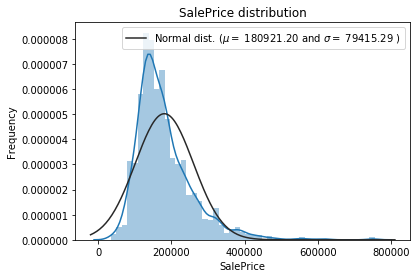

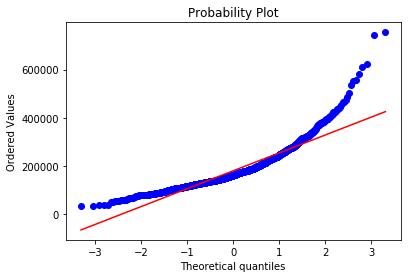

In [646]:
# Visualizing SalePrice vs. log(SalePrice)
# import seaborn and fit and skew functions from scipy
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Plotting Saleprice Distribution
sns.distplot(train2['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train2['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 180921.20 and sigma = 79415.29



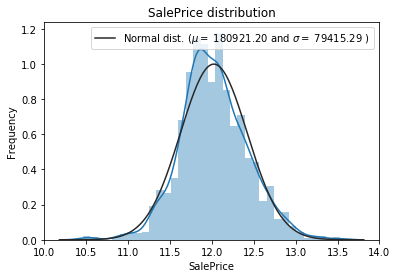

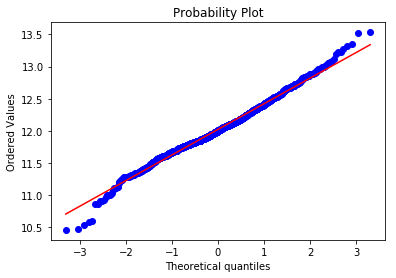

In [647]:
# Plotting log(Saleprice) Distribution and QQ Plot
sns.distplot(np.log(train2['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train2['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log(train['SalePrice']), plot=plt)
plt.show()

###### Creating new variable - log of SalePrice

In [648]:
train2['LogSalePrice'] = np.log(train2['SalePrice'])

In [649]:
print('Done')

Done


In [650]:
train2.shape

(1460, 113)

###### Creating y - logged SalePrice

In [651]:
y = train2.LogSalePrice

###### Need to select all quantitative variables again:

In [652]:
# Grab table of our variables as a pandas data frame
var_table = pd.read_csv('Data/House Prices Vars.csv')
# var_table.head()
# Grab all quant vars and dummies that we want to keep
quant_vars_all = var_table.loc[(var_table['Variable Type'] == 'numeric')|(var_table['Variable Type'] == 'dummy'), 'Vars. to Use']
pd.set_option('display.max_rows',150)
# print(quant_vars_all)
quant_vars_all.shape


(104,)

In [653]:
train2.to_csv('Data/train_all_vars.csv', index = False)
test2.to_csv('Data/test_all_vars.csv', index = False)

In [654]:
quant_vars_all.shape

(104,)

In [655]:
train2 = train2[quant_vars_all]
test2 = test2[quant_vars_all]

In [656]:
train2.shape

(1460, 104)

######  Transforming Necessary Numeric Features

In [657]:
# Boxcox Transformations
# numeric variables
numeric_vars = var_table.loc[var_table['Variable Type'] == 'numeric', 'Vars. to Use']

For: bsmt_exposure lambda= -2.16934846059


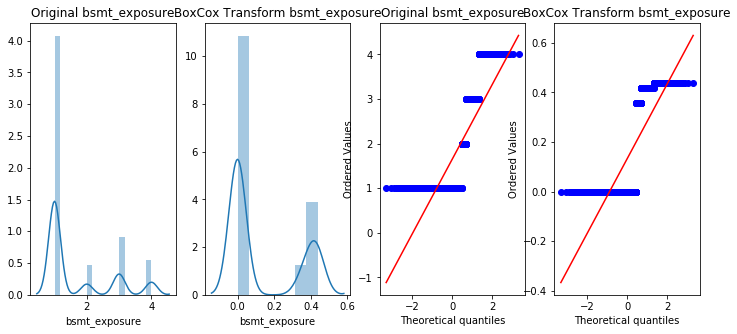

For: garage_perception lambda= 1.81704180085


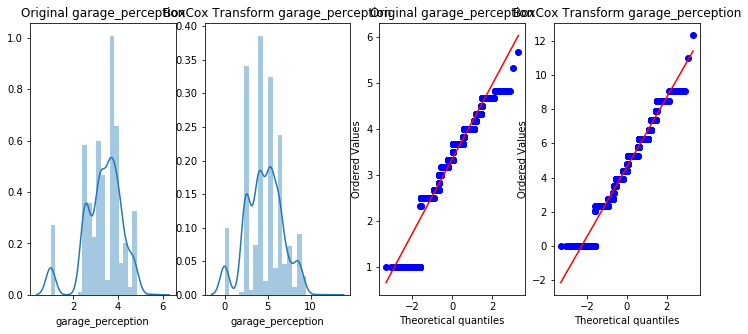

For: LotArea lambda= 0.030818544899


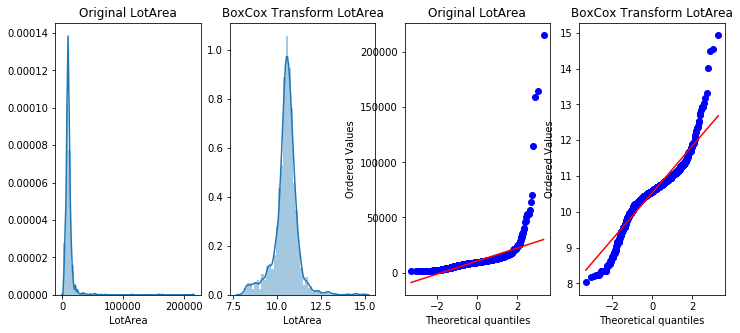

For: MasVnrArea lambda= -0.232807470374


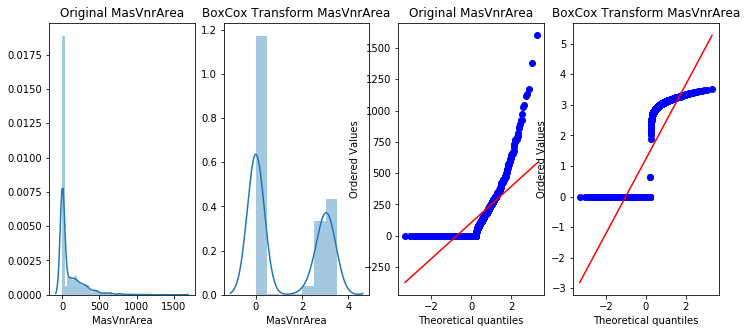

For: LowQualFinSF lambda= -10.0186373276


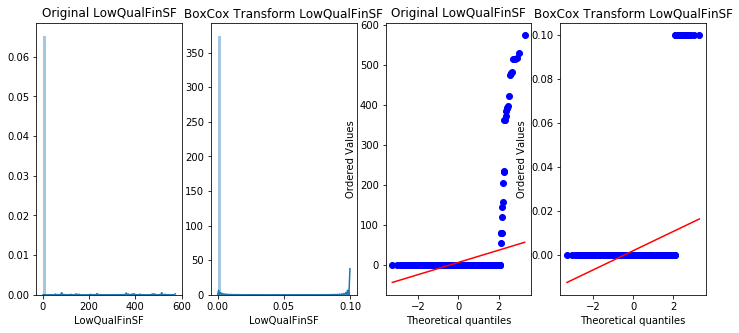

For: WoodDeckSF lambda= -0.0785961084869


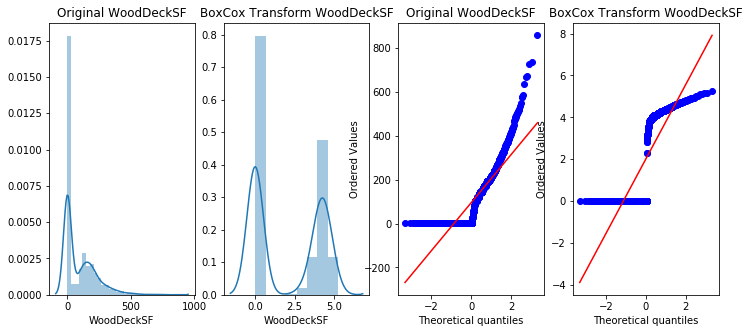

For: OpenPorchSF lambda= 0.0116427904888


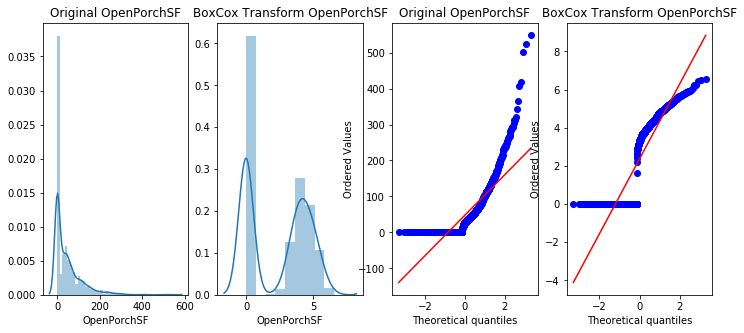

For: EnclosedPorch lambda= -1.41994923434


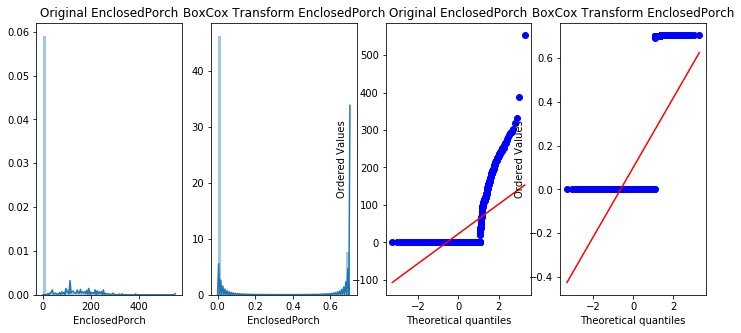

For: 3SsnPorch lambda= -11.6715354003


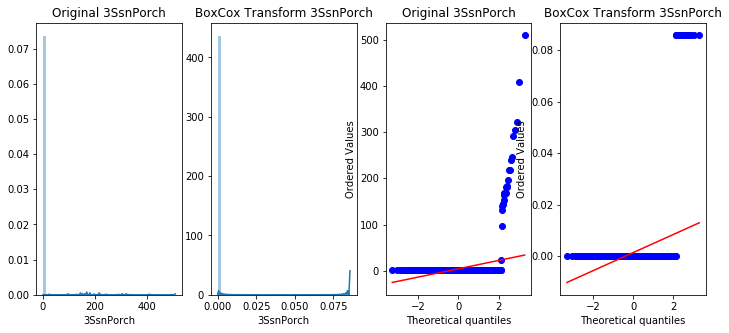

For: ScreenPorch lambda= -2.43486011288


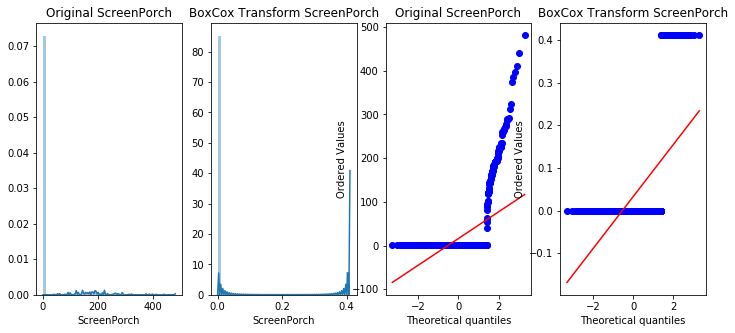

For: fence lambda= -7.80211985491


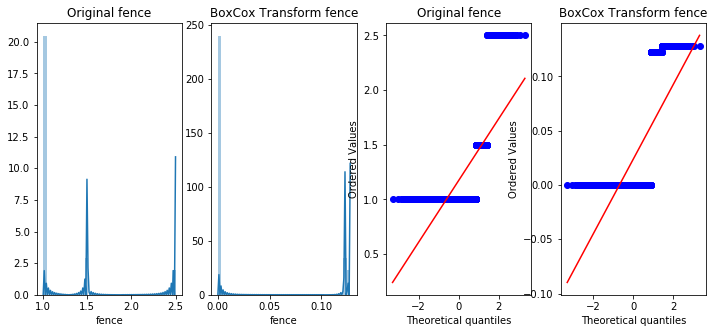

For: MiscVal lambda= -4.28346359818


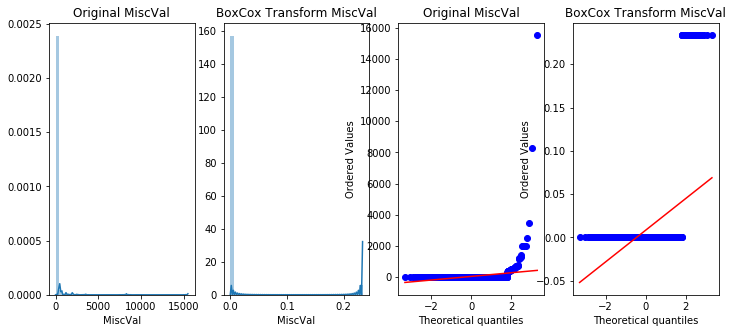

For: OverallCond lambda= 0.238459259302


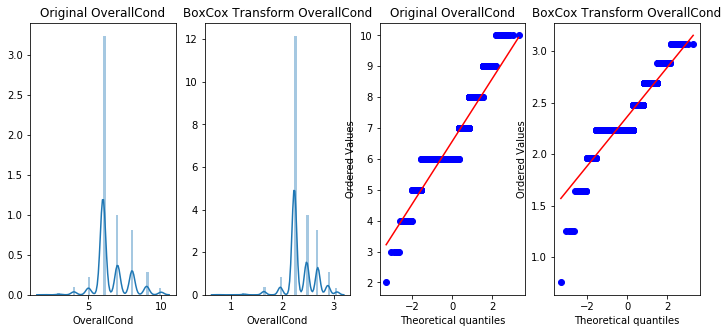

For: exterior_condition lambda= 0.130162203432


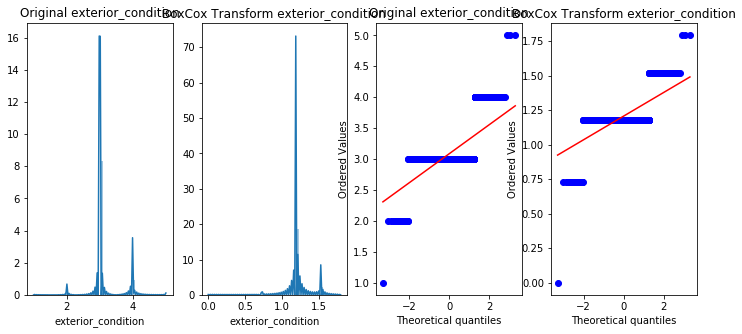

For: bsmt_condition lambda= 3.1919899473


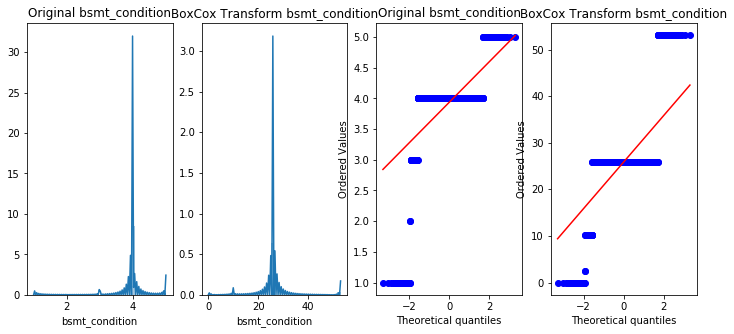

For: bsmt_finished1 lambda= 0.482993680635


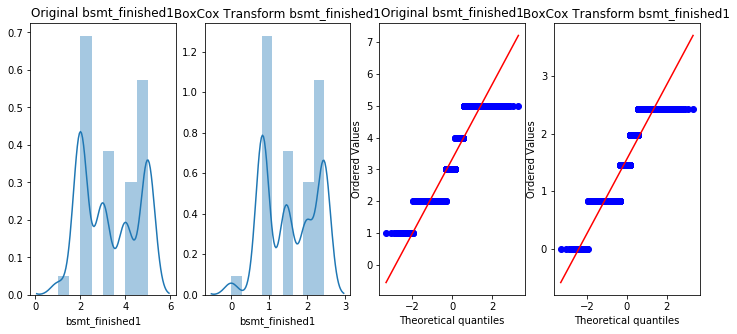

For: bsmt_finished2 lambda= -0.236011622589


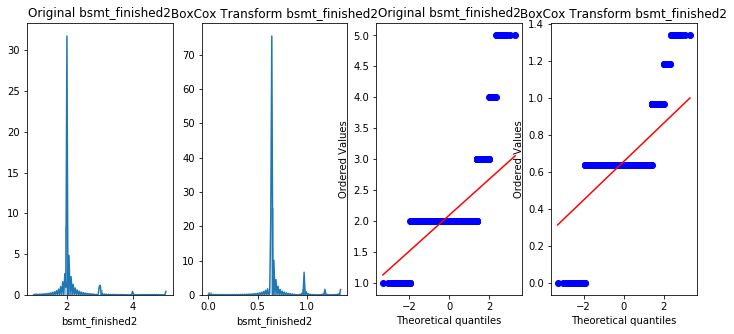

For: home_funct lambda= 27.9481082627


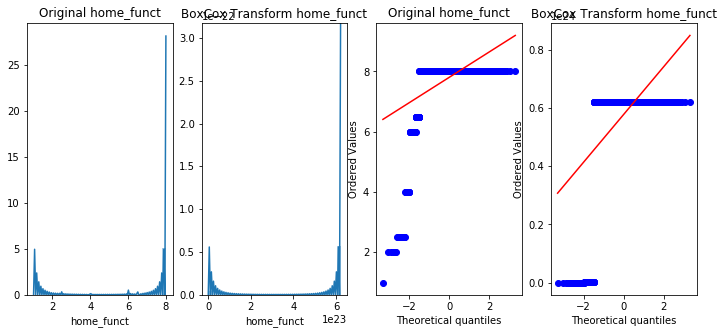

For: fireplace_ttlscore lambda= -0.239917408863


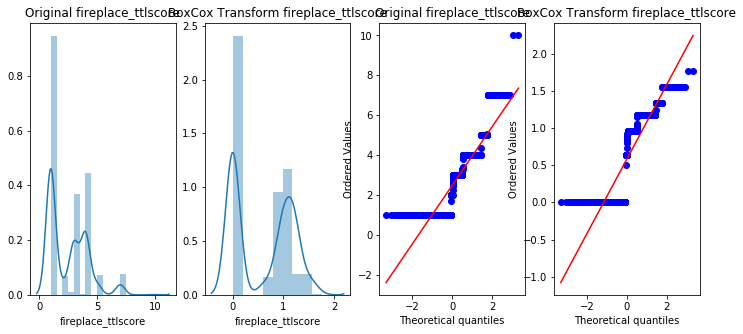

For: gar_perception lambda= 1.8295330334


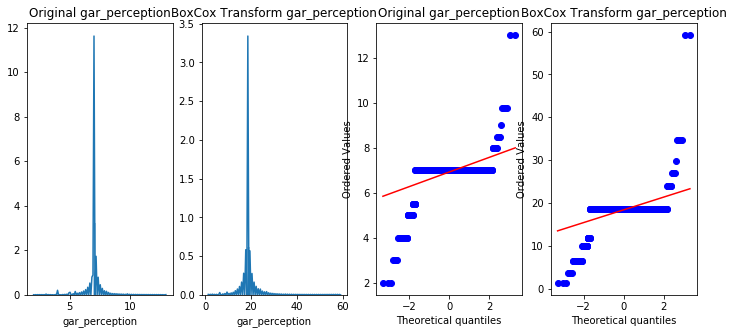

For: driveway lambda= 10.5574346882


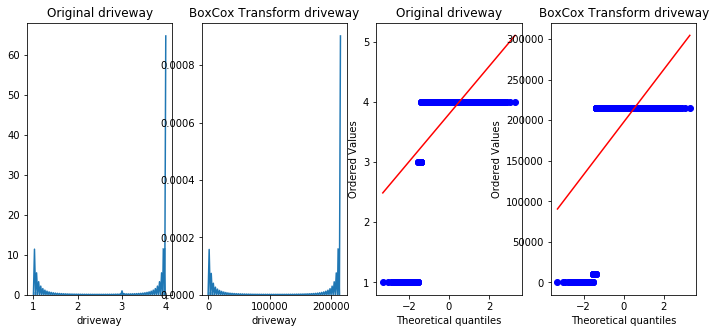

In [658]:
# Going to use BoxCox Transformation...
# First invetigate which variables will improve from transform
from boxcoxplot import pd_boxcox
bool_num = ["residual" not in i for i in numeric_vars]
#train3 = train2.copy()
for i in numeric_vars[bool_num]:
    # histogram and normal probability plot
    pd_boxcox(train2[i] +1, i, True)

In [325]:
# Transforming all values we found that boxcox worked...
# Included only: garage_perception, LotArea, OverallCond
from scipy.stats import boxcox
train2['garage_perception'],lmba_g = pd_boxcox(train2['garage_perception'] +1,'garage_perception', False)
test2['garage_perception'] = boxcox(test2['garage_perception'] +1, lmbda=lmba_g)
# lambda = 1.81704180085
train2['LotArea'],lmba_g2 = pd_boxcox(train2['LotArea'] +1,'LotArea', False)
test2['LotArea'] = boxcox(test2['LotArea'] +1, lmbda=lmba_g2)
# For: LotArea lambda= 0.030818544899
train2['OverallCond'],lmba_g3 = pd_boxcox(train2['OverallCond'] +1,'OverallCond', False)
test2['OverallCond'] = boxcox(test2['OverallCond'] +1, lmbda=lmba_g3)
# For: OverallCond lambda= 0.238459259302

For: garage_perception lambda= 1.81704180085
For: LotArea lambda= 0.030818544899
For: OverallCond lambda= 0.238459259302


In [2024]:
train2.shape

(1460, 104)

###### Standardizing all Variables in our training2 dataframe so that we can detect outliers

In [2025]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(train2), columns=train2.columns)

In [1331]:
# Checking it worked
# sum(temp.mean(axis = 0))
# sum(temp.std(axis = 0))
# temp.shape

###### Function to identify outliers (will use it once we are done with feature engineering)

###### Important!
1. Only run it once we are done with feature engineering!
2. Only run after we've imputed missing values!
3. Only run after we've standardized (scaled) all predictors!

In [2026]:
# Import the function outliers' defined in file 'outliers.py':
from outliers import outliers

In [2027]:
# Very important code to make sure .py files are run successfully:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1334]:
# list(temp.columns)

In [2028]:
temp = outliers(temp, list(temp.columns), kneighbors = 40)

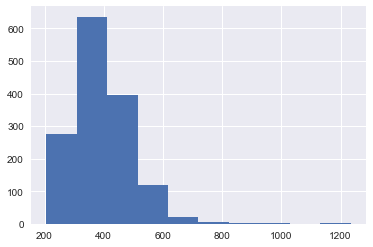

In [2029]:
plt.hist(temp.distances)
plt.show()

In [2030]:
temp.distances.quantile(q = 0.99)  # 99th percentile

681.5367715699703

In [1338]:
# temp.distances.sort_values(ascending = False)

In [2031]:
sum(temp.distances>690)

14

In [2032]:
sum(temp.distances>690)/temp.shape[0]*100

0.95890410958904115

In [2033]:
# Adding distances to our train2 data frame:
train2['distances'] = temp.distances

In [1342]:
# train2.distances.sort_values(ascending = False)

###### Executive decision was to remove 15 outliers with distance metrics > 690

In [2034]:
print(train2.shape)  # 1,460 rows

(1460, 105)


In [2035]:
y = y.loc[train2.distances < 690,]
train2 = train2.loc[train2.distances < 690,]

In [2036]:
print(train2.shape)
print(y.shape)

(1446, 105)
(1446,)


In [1346]:
# plt.scatter(train2.distances, y)

In [2037]:
# Drop distances from our training data frame:
t2_dists = train2['distances']
train2.drop(['distances'], axis=1, inplace = True)

###### Final Scaling of all predictors in training and test

In [2038]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(train2), columns=train2.columns)
temp2 = pd.DataFrame(scaler.transform(test2), columns = test2.columns)

In [2039]:
print(temp.shape)
print(temp2.shape)

(1446, 104)
(1459, 104)


### Saving Prepped Data

In [2040]:
train_y = y
train_x = temp
test_x = temp2
del temp
del temp2
del train2
del test2
train_y.to_csv('Data/train_y.csv', index=False)
train_x.to_csv('Data/train_x.csv', index=False)
test_x.to_csv('Data/test_x.csv', index=False)

In [2041]:
print('Done')

Done
